# Setup

In [1]:
print('Installing torchprofile...')
!pip install torchprofile 1>/dev/null
print('Installing fast-pytorch-kmeans...')
! pip install fast-pytorch-kmeans 1>/dev/null
print('All required packages have been successfully installed!')

Installing torchprofile...
Installing fast-pytorch-kmeans...
All required packages have been successfully installed!


In [2]:
import copy
import math
import random
from collections import OrderedDict, defaultdict

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *

from torchprofile import profile_macs

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

## Model

### Model dpt-swinv2-tiny-256

In [4]:
from transformers import DPTImageProcessor, DPTForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests

2024-04-20 12:43:34.542584: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-20 12:43:34.542686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-20 12:43:34.673730: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
processor = DPTImageProcessor.from_pretrained("Intel/dpt-swinv2-tiny-256")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-swinv2-tiny-256").to('cuda')

preprocessor_config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/164M [00:00<?, ?B/s]

In [6]:
next(model.parameters()).is_cuda

True

In [7]:
processor

DPTImageProcessor {
  "do_normalize": true,
  "do_pad": false,
  "do_rescale": true,
  "do_resize": true,
  "ensure_multiple_of": 1,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "DPTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "keep_aspect_ratio": false,
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 256,
    "width": 256
  },
  "size_divisor": null
}

In [8]:
model.eval()

DPTForDepthEstimation(
  (backbone): Swinv2Backbone(
    (embeddings): Swinv2Embeddings(
      (patch_embeddings): Swinv2PatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Swinv2Encoder(
      (layers): ModuleList(
        (0): Swinv2Stage(
          (blocks): ModuleList(
            (0-1): 2 x Swinv2Layer(
              (attention): Swinv2Attention(
                (self): Swinv2SelfAttention(
                  (continuous_position_bias_mlp): Sequential(
                    (0): Linear(in_features=2, out_features=512, bias=True)
                    (1): ReLU(inplace=True)
                    (2): Linear(in_features=512, out_features=3, bias=False)
                  )
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, 

### Config

In [9]:
config ={
    "General":{
        "device":"cuda",
        "type":"full",
        "model": model,
        "emb_dim":768,
        "hooks":[2, 5, 8, 11],
        "read":"projection",
        "resample_dim":256,
        "optim":"adam",
        "lr_backbone":1e-5,
        "lr_scratch":3e-4,
        "loss_depth":"ssi",
        "loss_segmentation":"ce",
        "momentum":0.9,
        "epochs":5,
        "batch_size":1,
        "path_model":"models",
        "path_predicted_images":"output",
        "seed":0,
        "patch_size":16
    },
    "Dataset":{
        "paths":{
            "path_dataset":"/kaggle/input",
            "list_datasets":["inria-fod", "nyuv2-fod", "posetrack-fod"],
            "path_images":"images",
            "path_segmentations":"segmentations",
            "path_depths":"depths"
        },
        "extensions":{
            "ext_images":".jpg",
            "ext_segmentations":".png",
            "ext_depths":".jpg"
        },
        "splits":{
            "split_train":0.6,
            "split_val":0.2,
            "split_test":0.2
        },
        "transforms":{
            "resize":256,
            "p_flip":0.5,
            "p_crop":0.3,
            "p_rot":0.2
        },
        "classes":{
            "1": {
                "name": "person",
                "color": [150,5,61]
            }
        }
    },
    "wandb":{
        "enable": False,
        "username":"younesbelkada",
        "images_to_show":3,
        "im_h":540,
        "im_w":980
    }
}

### Helper function

In [10]:
import os, errno
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from glob import glob
from PIL import Image
from torchvision import transforms, utils

In [11]:
def get_total_paths(path, ext):
    return glob(os.path.join(path, '*'+ext))

In [12]:
def get_transforms(config):
    im_size = config['Dataset']['transforms']['resize']
    transform_image = transforms.Compose([
        transforms.Resize((im_size, im_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    transform_depth = transforms.Compose([
        transforms.Resize((im_size, im_size)),
        transforms.Grayscale(num_output_channels=1) ,
        transforms.ToTensor()
    ])
    transform_seg = transforms.Compose([
        transforms.Resize((im_size, im_size), interpolation=transforms.InterpolationMode.NEAREST),
        ToMask(config['Dataset']['classes']),
    ])
    return transform_image, transform_depth, transform_seg

In [13]:
def get_splitted_dataset(config, split, dataset_name, path_images, path_depths, path_segmentation):
    list_files = [os.path.basename(im) for im in path_images]
    np.random.seed(config['General']['seed'])
    np.random.shuffle(list_files)
    if split == 'train':
        selected_files = list_files[:int(len(list_files)*config['Dataset']['splits']['split_train'])]
    elif split == 'val':
        selected_files = list_files[int(len(list_files)*config['Dataset']['splits']['split_train']):int(len(list_files)*config['Dataset']['splits']['split_train'])+int(len(list_files)*config['Dataset']['splits']['split_val'])]
    else:
        selected_files = list_files[int(len(list_files)*config['Dataset']['splits']['split_train'])+int(len(list_files)*config['Dataset']['splits']['split_val']):]

    path_images = [os.path.join(config['Dataset']['paths']['path_dataset'], dataset_name, config['Dataset']['paths']['path_images'], im[:-4]+config['Dataset']['extensions']['ext_images']) for im in selected_files]
    path_depths = [os.path.join(config['Dataset']['paths']['path_dataset'], dataset_name, config['Dataset']['paths']['path_depths'], im[:-4]+config['Dataset']['extensions']['ext_depths']) for im in selected_files]
    path_segmentation = [os.path.join(config['Dataset']['paths']['path_dataset'], dataset_name, config['Dataset']['paths']['path_segmentations'], im[:-4]+config['Dataset']['extensions']['ext_segmentations']) for im in selected_files]
    return path_images, path_depths, path_segmentation

### Custom Augmentation

In [14]:
import numpy as np
import torch

In [15]:
class ToMask(object):
    """
        Convert a 3 channel RGB image into a 1 channel segmentation mask
    """
    def __init__(self, palette_dictionnary):
        self.nb_classes = len(palette_dictionnary)
        # sort the dictionary of the classes by the sum of rgb value -> to have always background = 0
        # self.converted_dictionnary = {i: v for i, (k, v) in enumerate(sorted(palette_dictionnary.items(), key=lambda item: sum(item[1])))}
        self.palette_dictionnary = palette_dictionnary

    def __call__(self, pil_image):
        # avoid taking the alpha channel
        image_array = np.array(pil_image)[:, :, :3]
        # get only one channel for the output
        output_array = np.zeros(image_array.shape, dtype="int")[:, :, 0]

        for label in self.palette_dictionnary.keys():
            rgb_color = self.palette_dictionnary[label]['color']
            mask = (image_array == rgb_color)
            output_array[mask[:, :, 0]] = int(label)

        output_array = torch.from_numpy(output_array).unsqueeze(0).long()
        return output_array

### Dataset

In [16]:
import os
import random
from glob import glob

import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
from torch.utils.data.dataloader import default_collate
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF


In [17]:
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

In [18]:
def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = transforms.ToPILImage()(img.to('cpu').float())
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

In [19]:
class AutoFocusDataset(Dataset):
    """
        Dataset class for the AutoFocus Task. Requires for each image, its depth ground-truth and
        segmentation mask
        Args:
            :- config -: json config file
            :- dataset_name -: str
            :- split -: split ['train', 'val', 'test']
    """
    def __init__(self, config, dataset_name, split=None):
        self.split = split
        self.config = config

        path_images = os.path.join(config['Dataset']['paths']['path_dataset'], dataset_name, config['Dataset']['paths']['path_images'])
        path_depths = os.path.join(config['Dataset']['paths']['path_dataset'], dataset_name, config['Dataset']['paths']['path_depths'])
        path_segmentations = os.path.join(config['Dataset']['paths']['path_dataset'], dataset_name, config['Dataset']['paths']['path_segmentations'])
        
        self.paths_images = get_total_paths(path_images, config['Dataset']['extensions']['ext_images'])
        self.paths_depths = get_total_paths(path_depths, config['Dataset']['extensions']['ext_depths'])
        self.paths_segmentations = get_total_paths(path_segmentations, config['Dataset']['extensions']['ext_segmentations'])
        
        assert (self.split in ['train', 'test', 'val']), "Invalid split!"
        assert (len(self.paths_images) == len(self.paths_depths)), "Different number of instances between the input and the depth maps"
        assert (len(self.paths_images) == len(self.paths_segmentations)), "Different number of instances between the input and the segmentation maps"
        assert (config['Dataset']['splits']['split_train']+config['Dataset']['splits']['split_test']+config['Dataset']['splits']['split_val'] == 1), "Invalid splits (sum must be equal to 1)"
        # check for segmentation

      
        # utility func for splitting
        self.paths_images, self.paths_depths, self.paths_segmentations = get_splitted_dataset(config, self.split, dataset_name, self.paths_images, self.paths_depths, self.paths_segmentations)

        #----------------------------------------------------------------------------------------------------------------------------
        # Get the transforms
        self.transform_image, self.transform_depth, self.transform_seg = get_transforms(config)

        # get p_flip from config
        self.p_flip = config['Dataset']['transforms']['p_flip'] if split=='train' else 0
        self.p_crop = config['Dataset']['transforms']['p_crop'] if split=='train' else 0
        self.p_rot = config['Dataset']['transforms']['p_rot'] if split=='train' else 0
        self.resize = config['Dataset']['transforms']['resize']
        
    def __len__(self):
        """
            Function to get the number of images using the given list of images
        """
        return len(self.paths_images)
    
    def __getitem__(self, idx):
        """
            Getter function in order to get the triplet of images / depth maps and segmentation masks
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = self.transform_image(Image.open(self.paths_images[idx]))
        depth = self.transform_depth(Image.open(self.paths_depths[idx]))
        segmentation = self.transform_seg(Image.open(self.paths_segmentations[idx]))
        imgorig = image.clone()

        if random.random() < self.p_flip:
            image = TF.hflip(image)
            depth = TF.hflip(depth)
            segmentation = TF.hflip(segmentation)

        if random.random() < self.p_crop:
            random_size = random.randint(128, self.resize-1)
            max_size = self.resize - random_size
            left = int(random.random()*max_size)
            top = int(random.random()*max_size)
            image = TF.crop(image, top, left, random_size, random_size)
            depth = TF.crop(depth, top, left, random_size, random_size)
            segmentation = TF.crop(segmentation, top, left, random_size, random_size)
            image = transforms.Resize((self.resize, self.resize))(image)
            depth = transforms.Resize((self.resize, self.resize))(depth)
            segmentation = transforms.Resize((self.resize, self.resize), interpolation=transforms.InterpolationMode.NEAREST)(segmentation)

        if random.random() < self.p_rot:
            #rotate
            random_angle = random.random()*20 - 10 #[-10 ; 10]
            mask = torch.ones((1,self.resize,self.resize)) #useful for the resize at the end
            mask = TF.rotate(mask, random_angle, interpolation=transforms.InterpolationMode.BILINEAR)
            image = TF.rotate(image, random_angle, interpolation=transforms.InterpolationMode.BILINEAR)
            depth = TF.rotate(depth, random_angle, interpolation=transforms.InterpolationMode.BILINEAR)
            segmentation = TF.rotate(segmentation, random_angle, interpolation=transforms.InterpolationMode.NEAREST)
            #crop to remove black borders due to the rotation
            left = torch.argmax(mask[:,0,:]).item()
            top = torch.argmax(mask[:,:,0]).item()
            coin = min(left,top)
            size = self.resize - 2*coin
            image = TF.crop(image, coin, coin, size, size)
            depth = TF.crop(depth, coin, coin, size, size)
            segmentation = TF.crop(segmentation, coin, coin, size, size)
            #Resize
            image = transforms.Resize((self.resize, self.resize))(image)
            depth = transforms.Resize((self.resize, self.resize))(depth)
            segmentation = transforms.Resize((self.resize, self.resize), interpolation=transforms.InterpolationMode.NEAREST)(segmentation)
        # show([imgorig, image, depth, segmentation])
        # exit(0)
        return image, depth, segmentation

Dataloader

In [20]:
list_data = config['Dataset']['paths']['list_datasets']
list_data

['inria-fod', 'nyuv2-fod', 'posetrack-fod']

In [21]:
autofocus_datasets_train = [] #include 3 dataset 
for dataset_name in list_data:
     autofocus_datasets_train.append(AutoFocusDataset(config, dataset_name, 'train'))
train_data = ConcatDataset(autofocus_datasets_train)
train_dataloader = DataLoader(train_data, batch_size=config['General']['batch_size'], shuffle=True)
len(train_data)

1512

In [22]:
autofocus_datasets_test = [] #include 3 dataset 
for dataset_name in list_data:
     autofocus_datasets_test.append(AutoFocusDataset(config, dataset_name, 'test'))
test_data = ConcatDataset(autofocus_datasets_train)
test_dataloader = DataLoader(test_data, batch_size=config['General']['batch_size'], shuffle=True)
len(test_data)

1512

In [23]:
autofocus_datasets_val = []
for dataset_name in list_data:
    autofocus_datasets_val.append(AutoFocusDataset(config, dataset_name, 'val'))
val_data = ConcatDataset(autofocus_datasets_val)
val_dataloader = DataLoader(val_data, batch_size=config['General']['batch_size'], shuffle=True)
len(val_data)

504

## Loss function

In [24]:
import torch
import torch.nn as nn

In [25]:
def compute_scale_and_shift(prediction, target, mask):
    # system matrix: A = [[a_00, a_01], [a_10, a_11]]
    a_00 = torch.sum(mask * prediction * prediction, (1, 2))
    a_01 = torch.sum(mask * prediction, (1, 2))
    a_11 = torch.sum(mask, (1, 2))

    # right hand side: b = [b_0, b_1]
    b_0 = torch.sum(mask * prediction * target, (1, 2))
    b_1 = torch.sum(mask * target, (1, 2))

    # solution: x = A^-1 . b = [[a_11, -a_01], [-a_10, a_00]] / (a_00 * a_11 - a_01 * a_10) . b
    x_0 = torch.zeros_like(b_0)
    x_1 = torch.zeros_like(b_1)

    det = a_00 * a_11 - a_01 * a_01
    valid = det.nonzero()

    x_0[valid] = (a_11[valid] * b_0[valid] - a_01[valid] * b_1[valid]) / det[valid]
    x_1[valid] = (-a_01[valid] * b_0[valid] + a_00[valid] * b_1[valid]) / det[valid]

    return x_0, x_1

In [26]:
def reduction_batch_based(image_loss, M):
    # average of all valid pixels of the batch

    # avoid division by 0 (if sum(M) = sum(sum(mask)) = 0: sum(image_loss) = 0)
    divisor = torch.sum(M)

    if divisor == 0:
        return 0
    else:
        return torch.sum(image_loss) / divisor

In [27]:
def reduction_image_based(image_loss, M):
    # mean of average of valid pixels of an image

    # avoid division by 0 (if M = sum(mask) = 0: image_loss = 0)
    valid = M.nonzero()

    image_loss[valid] = image_loss[valid] / M[valid]

    return torch.mean(image_loss)

In [28]:
def mse_loss(prediction, target, mask, reduction=reduction_batch_based):

    M = torch.sum(mask, (1, 2))
    res = prediction - target
    image_loss = torch.sum(mask * res * res, (1, 2))

    return reduction(image_loss, 2 * M)

In [29]:
def gradient_loss(prediction, target, mask, reduction=reduction_batch_based):

    M = torch.sum(mask, (1, 2))

    diff = prediction - target
    diff = torch.mul(mask, diff)

    grad_x = torch.abs(diff[:, :, 1:] - diff[:, :, :-1])
    mask_x = torch.mul(mask[:, :, 1:], mask[:, :, :-1])
    grad_x = torch.mul(mask_x, grad_x)

    grad_y = torch.abs(diff[:, 1:, :] - diff[:, :-1, :])
    mask_y = torch.mul(mask[:, 1:, :], mask[:, :-1, :])
    grad_y = torch.mul(mask_y, grad_y)

    image_loss = torch.sum(grad_x, (1, 2)) + torch.sum(grad_y, (1, 2))

    return reduction(image_loss, M)

Scale and shift Loss

In [30]:
class ScaleAndShiftInvariantLoss(nn.Module):
    def __init__(self, alpha=0.5, scales=4, reduction='batch-based'):
        super().__init__()

        self.__data_loss = MSELoss(reduction=reduction)
        self.__regularization_loss = GradientLoss(scales=scales, reduction=reduction)
        self.__alpha = alpha

        self.__prediction_ssi = None

    def forward(self, prediction, target):
        #preprocessing
        mask = target > 0

        #calcul
        scale, shift = compute_scale_and_shift(prediction, target, mask)
        # print(scale, shift)
        self.__prediction_ssi = scale.view(-1, 1, 1) * prediction + shift.view(-1, 1, 1)

        total = self.__data_loss(self.__prediction_ssi, target, mask)
        if self.__alpha > 0:
            total += self.__alpha * self.__regularization_loss(self.__prediction_ssi, target, mask)

        return total

    def __get_prediction_ssi(self):
        return self.__prediction_ssi

    prediction_ssi = property(__get_prediction_ssi)

MSE loss

In [31]:
class MSELoss(nn.Module):
    def __init__(self, reduction='batch-based'):
        super().__init__()

        if reduction == 'batch-based':
            self.__reduction = reduction_batch_based
        else:
            self.__reduction = reduction_image_based

    def forward(self, prediction, target, mask):
        return mse_loss(prediction, target, mask, reduction=self.__reduction)


Gradient loss

In [32]:
class GradientLoss(nn.Module):
    def __init__(self, scales=4, reduction='batch-based'):
        super().__init__()

        if reduction == 'batch-based':
            self.__reduction = reduction_batch_based
        else:
            self.__reduction = reduction_image_based

        self.__scales = scales

    def forward(self, prediction, target, mask):
        total = 0

        for scale in range(self.__scales):
            step = pow(2, scale)

            total += gradient_loss(prediction[:, ::step, ::step], target[:, ::step, ::step],
                                   mask[:, ::step, ::step], reduction=self.__reduction)

        return total

## Training function

Utils

In [33]:
import os, errno
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from glob import glob
from PIL import Image
from torchvision import transforms, utils

In [34]:
def get_losses(config):
    def NoneFunction(a, b):
        return 0
    loss_depth = NoneFunction
    loss_segmentation = NoneFunction
    type = config['General']['type']
    if type == "full" or type=="depth":
        if config['General']['loss_depth'] == 'mse':
            loss_depth = nn.MSELoss()
        elif config['General']['loss_depth'] == 'ssi':
            loss_depth = ScaleAndShiftInvariantLoss()
    if type == "full" or type=="segmentation":
        if config['General']['loss_segmentation'] == 'ce':
            loss_segmentation = nn.CrossEntropyLoss()
    return loss_depth, loss_segmentation

In [35]:
def get_optimizer(config, net):
    names = set([name.split('.')[0] for name, _ in net.named_modules()]) - set(['', 'backbone'])
    params_backbone = net.backbone.parameters()
    params_scratch = list()
    for name in names:
        params_scratch += list(eval("net."+name).parameters())

    if config['General']['optim'] == 'adam':
        optimizer_backbone = optim.Adam(params_backbone, lr=config['General']['lr_backbone'])
        optimizer_scratch = optim.Adam(params_scratch, lr=config['General']['lr_scratch'])
    elif config['General']['optim'] == 'sgd':
        optimizer_backbone = optim.SGD(params_backbone, lr=config['General']['lr_backbone'], momentum=config['General']['momentum'])
        optimizer_scratch = optim.SGD(params_scratch, lr=config['General']['lr_scratch'], momentum=config['General']['momentum'])
    return optimizer_backbone, optimizer_scratch

In [36]:
def get_schedulers(optimizers):
    return [ReduceLROnPlateau(optimizer) for optimizer in optimizers]

In [37]:
def create_dir(directory):
    try:
        os.makedirs(directory)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

trainer 

In [38]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import wandb
import cv2
import torch.nn as nn

from tqdm import tqdm
from os import replace
from numpy.core.numeric import Inf

In [39]:
class Trainer(object):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.type = self.config['General']['type']

        self.device = torch.device(self.config['General']['device'] if torch.cuda.is_available() else "cpu")
        print("device: %s" % self.device)
        resize = config['Dataset']['transforms']['resize']
        
        self.model = model
        
        self.loss_depth, self.loss_segmentation = get_losses(config)
        self.optimizer_backbone, self.optimizer_scratch = get_optimizer(config, self.model)
        self.schedulers = get_schedulers([self.optimizer_backbone, self.optimizer_scratch])
        
    def train(self, train_dataloader, val_dataloader):
        epochs = self.config['General']['epochs']
        if self.config['wandb']['enable']:
            wandb.init(project="FocusOnDepth", entity=self.config['wandb']['username'])
            wandb.config = {
                "learning_rate_backbone": self.config['General']['lr_backbone'],
                "learning_rate_scratch": self.config['General']['lr_scratch'],
                "epochs": epochs,
                "batch_size": self.config['General']['batch_size']
            }
        val_loss = Inf
        for epoch in range(epochs):  # loop over the dataset multiple times
            print("Epoch ", epoch+1)
            running_loss = 0.0
            self.model.train()
            pbar = tqdm(train_dataloader)
            pbar.set_description("Training")
            for i, (X, Y_depths, Y_segmentations) in enumerate(pbar):
                X, Y_depths, Y_segmentations = X.to(self.device), Y_depths.to(self.device), Y_segmentations.to(self.device)
                self.optimizer_backbone.zero_grad()
                self.optimizer_scratch.zero_grad()
                output_depths = self.model(X)
    
                output_depths = output_depths['predicted_depth'].squeeze(1) if output_depths != None else None

                Y_depths = Y_depths.squeeze(1) #1xHxW -> HxW
                loss = self.loss_depth(output_depths, Y_depths)
                loss.backward()
                # step optimizer
                self.optimizer_scratch.step()
                self.optimizer_backbone.step()

                running_loss += loss.item()
                if np.isnan(running_loss):
                    print('\n',
                        X.min().item(), X.max().item(),'\n',
                        Y_depths.min().item(), Y_depths.max().item(),'\n',
                        output_depths.min().item(), output_depths.max().item(),'\n',
                        loss.item(),
                    )
                    exit(0)

                if self.config['wandb']['enable'] and ((i % 50 == 0 and i>0) or i==len(train_dataloader)-1):
                    wandb.log({"loss": running_loss/(i+1)})
                pbar.set_postfix({'training_loss': running_loss/(i+1)})

            new_val_loss = self.run_eval(val_dataloader)

            if new_val_loss < val_loss:
                self.save_model()
                val_loss = new_val_loss

            self.schedulers[0].step(new_val_loss)
            self.schedulers[1].step(new_val_loss)

        print('Finished Training')
        
    def run_eval(self, val_dataloader):
        """
            Evaluate the model on the validation set and visualize some results
            on wandb
            :- val_dataloader -: torch dataloader
        """
        val_loss = 0.
        self.model.eval()
        X_1 = None
        Y_depths_1 = None
        Y_segmentations_1 = None
        output_depths_1 = None
        output_segmentations_1 = None
        with torch.no_grad():
            pbar = tqdm(val_dataloader)
            pbar.set_description("Validation")
            for i, (X, Y_depths, Y_segmentations) in enumerate(pbar):
                X, Y_depths, Y_segmentations = X.to(self.device), Y_depths.to(self.device), Y_segmentations.to(self.device)
                output_depths = self.model(X)
                output_depths = output_depths['predicted_depth'].squeeze(1) if output_depths != None else None
                Y_depths = Y_depths.squeeze(1)
                if i==0:
                    X_1 = X
                    Y_depths_1 = Y_depths
                    output_depths_1 = output_depths

                loss = self.loss_depth(output_depths, Y_depths)
                val_loss += loss.item()
                pbar.set_postfix({'validation_loss': val_loss/(i+1)})
            if self.config['wandb']['enable']:
                wandb.log({"val_loss": val_loss/(i+1)})
                self.img_logger(X_1, Y_depths_1, Y_segmentations_1, output_depths_1, output_segmentations_1)
        return val_loss/(i+1)
    
    def save_model(self):
        path_model = os.path.join(self.config['General']['path_model'], self.model.__class__.__name__)
        create_dir(path_model)
        torch.save({'model_state_dict': self.model.state_dict(),
                    'optimizer_backbone_state_dict': self.optimizer_backbone.state_dict(),
                    'optimizer_scratch_state_dict': self.optimizer_scratch.state_dict()
                    }, path_model+'.p')
        print('Model saved at : {}'.format(path_model))

    
    def img_logger(self, X, Y_depths, Y_segmentations, output_depths, output_segmentations):
        nb_to_show = self.config['wandb']['images_to_show'] if self.config['wandb']['images_to_show'] <= len(X) else len(X)
        tmp = X[:nb_to_show].detach().cpu().numpy()
        imgs = (tmp - tmp.min()) / (tmp.max() - tmp.min())
        if output_depths != None:
            tmp = Y_depths[:nb_to_show].unsqueeze(1).detach().cpu().numpy()
            depth_truths = np.repeat(tmp, 3, axis=1)
            tmp = output_depths[:nb_to_show].unsqueeze(1).detach().cpu().numpy()
            tmp = np.repeat(tmp, 3, axis=1)
            #depth_preds = 1.0 - tmp
            depth_preds = tmp
        if output_segmentations != None:
            tmp = Y_segmentations[:nb_to_show].unsqueeze(1).detach().cpu().numpy()
            segmentation_truths = np.repeat(tmp, 3, axis=1).astype('float32')
            tmp = torch.argmax(output_segmentations[:nb_to_show], dim=1)
            tmp = tmp.unsqueeze(1).detach().cpu().numpy()
            tmp = np.repeat(tmp, 3, axis=1)
            segmentation_preds = tmp.astype('float32')
        imgs = imgs.transpose(0,2,3,1)
        if output_depths != None:
            depth_truths = depth_truths.transpose(0,2,3,1)
            depth_preds = depth_preds.transpose(0,2,3,1)
        if output_segmentations != None:
            segmentation_truths = segmentation_truths.transpose(0,2,3,1)
            segmentation_preds = segmentation_preds.transpose(0,2,3,1)
        output_dim = (int(self.config['wandb']['im_w']), int(self.config['wandb']['im_h']))

        wandb.log({
            "img": [wandb.Image(cv2.resize(im, output_dim), caption='img_{}'.format(i+1)) for i, im in enumerate(imgs)]
        })
        if output_depths != None:
            wandb.log({
                "depth_truths": [wandb.Image(cv2.resize(im, output_dim), caption='depth_truths_{}'.format(i+1)) for i, im in enumerate(depth_truths)],
                "depth_preds": [wandb.Image(cv2.resize(im, output_dim), caption='depth_preds_{}'.format(i+1)) for i, im in enumerate(depth_preds)]
            })
        if output_segmentations != None:
            wandb.log({
                "seg_truths": [wandb.Image(cv2.resize(im, output_dim), caption='seg_truths_{}'.format(i+1)) for i, im in enumerate(segmentation_truths)],
                "seg_preds": [wandb.Image(cv2.resize(im, output_dim), caption='seg_preds_{}'.format(i+1)) for i, im in enumerate(segmentation_preds)]
            })

In [40]:
def eval_fn(model, val_dataloader):
        """
            Evaluate the model on the validation set and visualize some results
            on wandb
            :- model -: torch model using for evaluate
            :- val_dataloader -: torch dataloader
        """
        loss_depth, loss_segmentation = get_losses(config)
        device = torch.device(config['General']['device'] if torch.cuda.is_available() else "cpu")
        
        val_loss = 0.
        model.eval()
        
        #
        X_1 = None 
        Y_depths_1 = None
        output_depths_1 = None
        
        #
        with torch.no_grad():
            for i, (X, Y_depths, _) in enumerate(val_dataloader):
                X, Y_depths = X.to(device), Y_depths.to(device)
                output_depths = model(X)
                output_depths = output_depths['predicted_depth'].squeeze(1) if output_depths != None else None
                Y_depths = Y_depths.squeeze(1)
                if i==0:
                    X_1 = X
                    Y_depths_1 = Y_depths
                    output_depths_1 = output_depths
                    
                # get loss
                loss = loss_depth(output_depths, Y_depths)
                val_loss += loss.item()
#                 pbar.set_postfix({'validation_loss': val_loss/(i+1)})
        return val_loss/(i+1)

In [41]:
# trainer = Trainer(config)
# trainer.train(train_dataloader, val_dataloader)

In [42]:
model_path = "/kaggle/input/weight-dpt-swin2-tiny-256-ssiloss/models/DPTForDepthEstimation-ssi.pt"

checkpoint = torch.load(model_path)

In [43]:
type(checkpoint)

collections.OrderedDict

In [44]:
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [45]:
model.eval()

DPTForDepthEstimation(
  (backbone): Swinv2Backbone(
    (embeddings): Swinv2Embeddings(
      (patch_embeddings): Swinv2PatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Swinv2Encoder(
      (layers): ModuleList(
        (0): Swinv2Stage(
          (blocks): ModuleList(
            (0-1): 2 x Swinv2Layer(
              (attention): Swinv2Attention(
                (self): Swinv2SelfAttention(
                  (continuous_position_bias_mlp): Sequential(
                    (0): Linear(in_features=2, out_features=512, bias=True)
                    (1): ReLU(inplace=True)
                    (2): Linear(in_features=512, out_features=3, bias=False)
                  )
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, 

Recover model

In [46]:
recover_model = lambda : model.load_state_dict(checkpoint)

# First Evaluate the Accuracy and Model Size of the FP32 Model

In [47]:
def get_model_size(model: nn.Module, data_width=32):
    """
    calculate the model size in bits
    :param data_width: #bits per element
    """
    num_elements = 0
    for param in model.parameters():
        num_elements += param.numel()
    return num_elements * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [48]:
fp32_model_accuracy = eval_fn(model, test_dataloader)
fp32_model_size = get_model_size(model)
print(f"fp32 model has ssi loss={fp32_model_accuracy:.2f}")
print(f"fp32 model has size={fp32_model_size/MiB:.2f} MiB")

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


fp32 model has ssi loss=0.03
fp32 model has size=156.14 MiB


# K-Means Quantization

In [49]:
from collections import namedtuple
    
Codebook = namedtuple('Codebook', ['centroids', 'labels'])

In [50]:
Codebook

__main__.Codebook

### Question 1

In [51]:
from fast_pytorch_kmeans import KMeans

In [52]:
KMeans

fast_pytorch_kmeans.kmeans.KMeans

In [53]:
def test_k_means_quantize(
    test_tensor=torch.tensor([
        [-0.3747,  0.0874,  0.3200, -0.4868,  0.4404],
        [-0.0402,  0.2322, -0.2024, -0.4986,  0.1814],
        [ 0.3102, -0.3942, -0.2030,  0.0883, -0.4741],
        [-0.1592, -0.0777, -0.3946, -0.2128,  0.2675],
        [ 0.0611, -0.1933, -0.4350,  0.2928, -0.1087]]),
    bitwidth=2):
    def plot_matrix(tensor, ax, title, cmap=ListedColormap(['white'])):
        ax.imshow(tensor.cpu().numpy(), vmin=-0.5, vmax=0.5, cmap=cmap)
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    fig, axes = plt.subplots(1,2, figsize=(8, 12))
    ax_left, ax_right = axes.ravel()

    print(test_tensor)
    plot_matrix(test_tensor, ax_left, 'original tensor')

    num_unique_values_before_quantization = test_tensor.unique().numel()
    k_means_quantize(test_tensor, bitwidth=bitwidth)
    num_unique_values_after_quantization = test_tensor.unique().numel()
    print('* Test k_means_quantize()')
    print(f'    target bitwidth: {bitwidth} bits')
    print(f'        num unique values before k-means quantization: {num_unique_values_before_quantization}')
    print(f'        num unique values after  k-means quantization: {num_unique_values_after_quantization}')
    assert num_unique_values_after_quantization == min((1 << bitwidth), num_unique_values_before_quantization)
    print('* Test passed.')

    plot_matrix(test_tensor, ax_right, f'{bitwidth}-bit k-means quantized tensor', cmap='tab20c')
    fig.tight_layout()
    plt.show()

bitwitdh, quant to n bit

In [54]:
def k_means_quantize(fp32_tensor: torch.Tensor, bitwidth=4, codebook=None):
    """
    quantize tensor using k-means clustering
    :param fp32_tensor:
    :param bitwidth: [int] quantization bit width, default=4
    :param codebook: [Codebook] (the cluster centroids, the cluster label tensor)
    :return:
        [Codebook = (centroids, labels)]
            centroids: [torch.(cuda.)FloatTensor] the cluster centroids
            labels: [torch.(cuda.)LongTensor] cluster label tensor
    """
    if codebook is None:
        n_clusters = 2**bitwidth
        kmeans = KMeans(n_clusters=n_clusters, mode='euclidean', verbose=0)
        labels = kmeans.fit_predict(fp32_tensor.view(-1, 1)).to(torch.long)
        centroids = kmeans.centroids.to(torch.float).view(-1)
        codebook = Codebook(centroids, labels)
    quantized_tensor = codebook.centroids[codebook.labels]
    fp32_tensor.set_(quantized_tensor.view_as(fp32_tensor))
    return codebook

tensor([[-0.3747,  0.0874,  0.3200, -0.4868,  0.4404],
        [-0.0402,  0.2322, -0.2024, -0.4986,  0.1814],
        [ 0.3102, -0.3942, -0.2030,  0.0883, -0.4741],
        [-0.1592, -0.0777, -0.3946, -0.2128,  0.2675],
        [ 0.0611, -0.1933, -0.4350,  0.2928, -0.1087]])
* Test k_means_quantize()
    target bitwidth: 2 bits
        num unique values before k-means quantization: 25
        num unique values after  k-means quantization: 4
* Test passed.


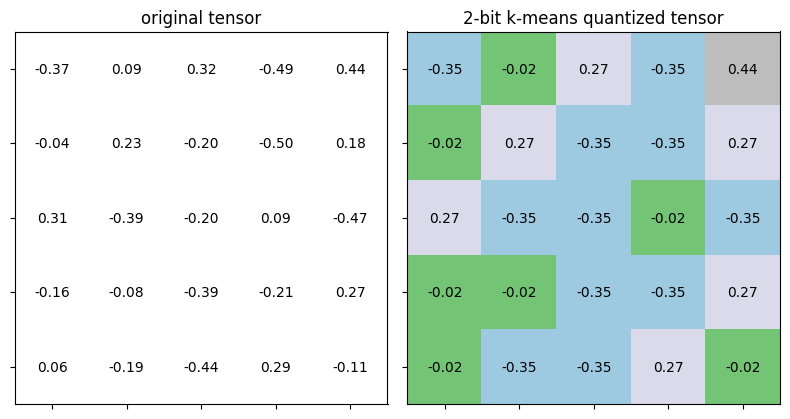

In [55]:
test_k_means_quantize()

## K-Means Quantization on Whole Model

In [56]:
from torch.nn import parameter

In [57]:
parameter

<module 'torch.nn.parameter' from '/opt/conda/lib/python3.10/site-packages/torch/nn/parameter.py'>

In [58]:
class KMeansQuantizer:
    def __init__(self, model : nn.Module, bitwidth=4):
        self.codebook = KMeansQuantizer.quantize(model, bitwidth)
        
    @torch.no_grad()
    def apply(self, model, update_centroids):
        for name, param in model.named_parameters():
            if name in self.codebook:
                if update_centroids:
                    update_codebook(param, codebook=self.codebook[name])
                self.codebook[name] = k_means_quantize(
                    param, codebook=self.codebook[name])
                
    @staticmethod
    @torch.no_grad()
    def quantize(model: nn.Module, bitwidth=4):
        codebook = dict()
        if isinstance(bitwidth, dict):
            for name, param in model.named_parameters():
                if name in bitwidth:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth[name])
        else:
            for name, param in model.named_parameters():
                # print(f"{name=}: {param.shape}")
                # only quantize weight, not bias
                if param.dim() > 1:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth)
        return codebook

Now let's quantize model into 8 bits, 4 bits and 2 bits using K-Means Quantization. Note that we ignore the storage for codebooks when calculating the model size.

In [59]:
print('Note that the storage for codebooks is ignored when calculating the model size.')
quantizers = dict()
for bitwidth in [8, 4, 2]:
    # Recover model
    recover_model()
    print(f'k-means quantizing model into {bitwidth} bits')
    quantizer = KMeansQuantizer(model, bitwidth)
    quantized_model_size = get_model_size(model, bitwidth)
    print(f"    {bitwidth}-bit k-means quantized model has size={quantized_model_size/MiB:.2f} MiB")
    quantized_model_accuracy = eval_fn(model, test_dataloader)
    print(f"    {bitwidth}-bit k-means quantized model has ssi loss={quantized_model_accuracy:.2f}")
    quantizers[bitwidth] = quantizer

Note that the storage for codebooks is ignored when calculating the model size.
k-means quantizing model into 8 bits
    8-bit k-means quantized model has size=39.03 MiB
    8-bit k-means quantized model has ssi loss=0.03
k-means quantizing model into 4 bits
    4-bit k-means quantized model has size=19.52 MiB
    4-bit k-means quantized model has ssi loss=0.07
k-means quantizing model into 2 bits
    2-bit k-means quantized model has size=9.76 MiB
    2-bit k-means quantized model has ssi loss=0.11


## Trained K-Means Quantization

Question 3: codebook update function

In [60]:
def update_codebook(fp32_tensor: torch.Tensor, codebook: Codebook):
    """
    update the centroids in the codebook using updated fp32_tensor
    :param fp32_tensor: [torch.(cuda.)Tensor]
    :param codebook: [Codebook] (the cluster centroids, the cluster label tensor)
    """
    n_clusters = codebook.centroids.numel()
    fp32_tensor = fp32_tensor.view(-1)
    for k in range(n_clusters):
    ############### YOUR CODE STARTS HERE ###############
        # hint: one line of code
        codebook.centroids[k] = torch.mean(fp32_tensor[codebook.labels==k])
    ############### YOUR CODE ENDS HERE #################

In [61]:
accuracy_drop_threshold = 0.05
quantizers_before_finetune = copy.deepcopy(quantizers)
quantizers_after_finetune = quantizers

In [62]:
for bitwidth in [8, 4, 2]:
    recover_model()
    quantizer = quantizers[bitwidth]
    print(f'k-means quantizing model into {bitwidth} bits')
    quantizer.apply(model, update_centroids=False)
    quantized_model_size = get_model_size(model, bitwidth)
    print(f"    {bitwidth}-bit k-means quantized model has size={quantized_model_size/MiB:.2f} MiB")
    quantized_model_accuracy = eval_fn(model, test_dataloader)
    print(f"    {bitwidth}-bit k-means quantized model has ssi loss={quantized_model_accuracy:.2f} before quantization-aware training ")
    accuracy_drop = abs(fp32_model_accuracy - quantized_model_accuracy)
    if accuracy_drop > accuracy_drop_threshold:
        print(f"        Quantization-aware training due to ssi loss drop={accuracy_drop:.2f} is larger than threshold={accuracy_drop_threshold:.2f}%")
        trainer = Trainer(config)
        trainer.train(train_dataloader, val_dataloader)
    else:
        print(f"        No need for quantization-aware training since ssi loss drop={accuracy_drop:.2f} is smaller than threshold={accuracy_drop_threshold:.2f}")
     

k-means quantizing model into 8 bits
    8-bit k-means quantized model has size=39.03 MiB
    8-bit k-means quantized model has ssi loss=0.03 before quantization-aware training 
        No need for quantization-aware training since ssi loss drop=0.00 is smaller than threshold=0.05
k-means quantizing model into 4 bits
    4-bit k-means quantized model has size=19.52 MiB
    4-bit k-means quantized model has ssi loss=0.07 before quantization-aware training 
        No need for quantization-aware training since ssi loss drop=0.03 is smaller than threshold=0.05
k-means quantizing model into 2 bits
    2-bit k-means quantized model has size=9.76 MiB
    2-bit k-means quantized model has ssi loss=0.11 before quantization-aware training 
        Quantization-aware training due to ssi loss drop=0.08 is larger than threshold=0.05%
device: cuda
Epoch  1


Validation: 100%|██████████| 504/504 [00:48<00:00, 10.36it/s, validation_loss=0.0525]


Model saved at : models/DPTForDepthEstimation
Epoch  2


Validation: 100%|██████████| 504/504 [00:36<00:00, 13.81it/s, validation_loss=0.0419]


Model saved at : models/DPTForDepthEstimation
Epoch  3


Validation: 100%|██████████| 504/504 [00:36<00:00, 13.64it/s, validation_loss=0.0384]


Model saved at : models/DPTForDepthEstimation
Epoch  4


Validation: 100%|██████████| 504/504 [00:37<00:00, 13.51it/s, validation_loss=0.0366]


Model saved at : models/DPTForDepthEstimation
Epoch  5


Validation: 100%|██████████| 504/504 [00:36<00:00, 13.77it/s, validation_loss=0.036] 


Model saved at : models/DPTForDepthEstimation
Finished Training


# Linear Quantization

## n-bit Integer

In [63]:
def get_quantized_range(bitwidth):
    quantized_max = (1 << (bitwidth - 1)) - 1
    quantized_min = -(1 << (bitwidth - 1))
    return quantized_min, quantized_max

In [64]:
get_quantized_range(8)

(-128, 127)

In [65]:
get_quantized_range(4)

(-8, 7)

In [66]:
get_quantized_range(2)

(-2, 1)

Question 4: Linear quantization function

In [67]:
def linear_quantize(fp_tensor, bitwidth, scale, zero_point, dtype=torch.int8) -> torch.Tensor:
    """
    linear quantization for single fp_tensor
      from
        fp_tensor = (quantized_tensor - zero_point) * scale
      we have,
        quantized_tensor = int(round(fp_tensor / scale)) + zero_point
    :param tensor: [torch.(cuda.)FloatTensor] floating tensor to be quantized
    :param bitwidth: [int] quantization bit width
    :param scale: [torch.(cuda.)FloatTensor] scaling factor
    :param zero_point: [torch.(cuda.)IntTensor] the desired centroid of tensor values
    :return:
        [torch.(cuda.)FloatTensor] quantized tensor whose values are integers
    """
    assert(fp_tensor.dtype == torch.float)
    assert(isinstance(scale, float) or
           (scale.dtype == torch.float and scale.dim() == fp_tensor.dim()))
    assert(isinstance(zero_point, int) or
           (zero_point.dtype == dtype and zero_point.dim() == fp_tensor.dim()))

    ############### YOUR CODE STARTS HERE ###############
    # Step 1: scale the fp_tensor
    scaled_tensor = fp_tensor / scale
    # Step 2: round the floating value to integer value
    rounded_tensor = torch.round(scaled_tensor)
    ############### YOUR CODE ENDS HERE #################

    rounded_tensor = rounded_tensor.to(dtype)

    ############### YOUR CODE STARTS HERE ###############
    # Step 3: shift the rounded_tensor to make zero_point 0
    shifted_tensor = rounded_tensor + zero_point
    ############### YOUR CODE ENDS HERE #################

    # Step 4: clamp the shifted_tensor to lie in bitwidth-bit range
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    quantized_tensor = shifted_tensor.clamp_(quantized_min, quantized_max)
    return quantized_tensor

Test linear quant

In [68]:
def test_linear_quantize(
    test_tensor=torch.tensor([
        [ 0.0523,  0.6364, -0.0968, -0.0020,  0.1940],
        [ 0.7500,  0.5507,  0.6188, -0.1734,  0.4677],
        [-0.0669,  0.3836,  0.4297,  0.6267, -0.0695],
        [ 0.1536, -0.0038,  0.6075,  0.6817,  0.0601],
        [ 0.6446, -0.2500,  0.5376, -0.2226,  0.2333]]),
    quantized_test_tensor=torch.tensor([
        [-1,  1, -1, -1,  0],
        [ 1,  1,  1, -2,  0],
        [-1,  0,  0,  1, -1],
        [-1, -1,  1,  1, -1],
        [ 1, -2,  1, -2,  0]], dtype=torch.int8),
    real_min=-0.25, real_max=0.75, bitwidth=2, scale=1/3, zero_point=-1):
    def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=ListedColormap(['white'])):
        ax.imshow(tensor.cpu().numpy(), vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[0]):
            for j in range(tensor.shape[1]):
                datum = tensor[i, j].item()
                if isinstance(datum, float):
                    text = ax.text(j, i, f'{datum:.2f}',
                                    ha="center", va="center", color="k")
                else:
                    text = ax.text(j, i, f'{datum}',
                                    ha="center", va="center", color="k")
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    fig, axes = plt.subplots(1,3, figsize=(10, 32))
    plot_matrix(test_tensor, axes[0], 'original tensor', vmin=real_min, vmax=real_max)
    _quantized_test_tensor = linear_quantize(
        test_tensor, bitwidth=bitwidth, scale=scale, zero_point=zero_point)
    _reconstructed_test_tensor = scale * (_quantized_test_tensor.float() - zero_point)
    print('* Test linear_quantize()')
    print(f'    target bitwidth: {bitwidth} bits')
    print(f'        scale: {scale}')
    print(f'        zero point: {zero_point}')
    assert _quantized_test_tensor.equal(quantized_test_tensor)
    print('* Test passed.')
    plot_matrix(_quantized_test_tensor, axes[1], f'2-bit linear quantized tensor',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(_reconstructed_test_tensor, axes[2], f'reconstructed tensor',
                vmin=real_min, vmax=real_max, cmap='tab20c')
    fig.tight_layout()
    plt.show()

     

def test_quantized_fc(
    input=torch.tensor([
        [0.6118, 0.7288, 0.8511, 0.2849, 0.8427, 0.7435, 0.4014, 0.2794],
        [0.3676, 0.2426, 0.1612, 0.7684, 0.6038, 0.0400, 0.2240, 0.4237],
        [0.6565, 0.6878, 0.4670, 0.3470, 0.2281, 0.8074, 0.0178, 0.3999],
        [0.1863, 0.3567, 0.6104, 0.0497, 0.0577, 0.2990, 0.6687, 0.8626]]),
    weight=torch.tensor([
        [ 1.2626e-01, -1.4752e-01,  8.1910e-02,  2.4982e-01, -1.0495e-01,
         -1.9227e-01, -1.8550e-01, -1.5700e-01],
        [ 2.7624e-01, -4.3835e-01,  5.1010e-02, -1.2020e-01, -2.0344e-01,
          1.0202e-01, -2.0799e-01,  2.4112e-01],
        [-3.8216e-01, -2.8047e-01,  8.5238e-02, -4.2504e-01, -2.0952e-01,
          3.2018e-01, -3.3619e-01,  2.0219e-01],
        [ 8.9233e-02, -1.0124e-01,  1.1467e-01,  2.0091e-01,  1.1438e-01,
         -4.2427e-01,  1.0178e-01, -3.0941e-04],
        [-1.8837e-02, -2.1256e-01, -4.5285e-01,  2.0949e-01, -3.8684e-01,
         -1.7100e-01, -4.5331e-01, -2.0433e-01],
        [-2.0038e-01, -5.3757e-02,  1.8997e-01, -3.6866e-01,  5.5484e-02,
          1.5643e-01, -2.3538e-01,  2.1103e-01],
        [-2.6875e-01,  2.4984e-01, -2.3514e-01,  2.5527e-01,  2.0322e-01,
          3.7675e-01,  6.1563e-02,  1.7201e-01],
        [ 3.3541e-01, -3.3555e-01, -4.3349e-01,  4.3043e-01, -2.0498e-01,
         -1.8366e-01, -9.1553e-02, -4.1168e-01]]),
    bias=torch.tensor([ 0.1954, -0.2756,  0.3113,  0.1149,  0.4274,  0.2429, -0.1721, -0.2502]),
    quantized_bias=torch.tensor([ 3, -2,  3,  1,  3,  2, -2, -2], dtype=torch.int32),
    shifted_quantized_bias=torch.tensor([-1,  0, -3, -1, -3,  0,  2, -4], dtype=torch.int32),
    calc_quantized_output=torch.tensor([
        [ 0, -1,  0, -1, -1,  0,  1, -2],
        [ 0,  0, -1,  0,  0,  0,  0, -1],
        [ 0,  0,  0, -1,  0,  0,  0, -1],
        [ 0,  0,  0,  0,  0,  1, -1, -2]], dtype=torch.int8),
    bitwidth=2, batch_size=4, in_channels=8, out_channels=8):
    def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=ListedColormap(['white'])):
        ax.imshow(tensor.cpu().numpy(), vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[0]):
            for j in range(tensor.shape[1]):
                datum = tensor[i, j].item()
                if isinstance(datum, float):
                    text = ax.text(j, i, f'{datum:.2f}',
                                    ha="center", va="center", color="k")
                else:
                    text = ax.text(j, i, f'{datum}',
                                    ha="center", va="center", color="k")

    output = torch.nn.functional.linear(input, weight, bias)

    quantized_weight, weight_scale, weight_zero_point = \
        linear_quantize_weight_per_channel(weight, bitwidth)
    quantized_input, input_scale, input_zero_point = \
        linear_quantize_feature(input, bitwidth)
    _quantized_bias, bias_scale, bias_zero_point = \
        linear_quantize_bias_per_output_channel(bias, weight_scale, input_scale)


    assert _quantized_bias.equal(quantized_bias) # original: _quantized_bias.equal(_quantized_bias)
    _shifted_quantized_bias = \
        shift_quantized_linear_bias(quantized_bias, quantized_weight, input_zero_point)
    assert _shifted_quantized_bias.equal(shifted_quantized_bias)
    quantized_output, output_scale, output_zero_point = \
        linear_quantize_feature(output, bitwidth)

    _calc_quantized_output = quantized_linear(
        quantized_input, quantized_weight, shifted_quantized_bias,
        bitwidth, bitwidth,
        input_zero_point, output_zero_point,
        input_scale, weight_scale, output_scale)

    assert _calc_quantized_output.equal(calc_quantized_output)

    reconstructed_weight = weight_scale * (quantized_weight.float() - weight_zero_point)
    reconstructed_input = input_scale * (quantized_input.float() - input_zero_point)
    reconstructed_bias = bias_scale * (quantized_bias.float() - bias_zero_point)
    reconstructed_calc_output = output_scale * (calc_quantized_output.float() - output_zero_point)

    fig, axes = plt.subplots(3,3, figsize=(15, 12))
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    plot_matrix(weight, axes[0, 0], 'original weight', vmin=-0.5, vmax=0.5)
    plot_matrix(input.t(), axes[1, 0], 'original input', vmin=0, vmax=1)
    plot_matrix(output.t(), axes[2, 0], 'original output', vmin=-1.5, vmax=1.5)
    plot_matrix(quantized_weight, axes[0, 1], f'{bitwidth}-bit linear quantized weight',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(quantized_input.t(), axes[1, 1], f'{bitwidth}-bit linear quantized input',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(calc_quantized_output.t(), axes[2, 1], f'quantized output from quantized_linear()',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(reconstructed_weight, axes[0, 2], f'reconstructed weight',
                vmin=-0.5, vmax=0.5, cmap='tab20c')
    plot_matrix(reconstructed_input.t(), axes[1, 2], f'reconstructed input',
                vmin=0, vmax=1, cmap='tab20c')
    plot_matrix(reconstructed_calc_output.t(), axes[2, 2], f'reconstructed output',
                vmin=-1.5, vmax=1.5, cmap='tab20c')

    print('* Test quantized_fc()')
    print(f'    target bitwidth: {bitwidth} bits')
    print(f'      batch size: {batch_size}')
    print(f'      input channels: {in_channels}')
    print(f'      output channels: {out_channels}')
    print('* Test passed.')
    fig.tight_layout()
    plt.show()

* Test linear_quantize()
    target bitwidth: 2 bits
        scale: 0.3333333333333333
        zero point: -1
* Test passed.


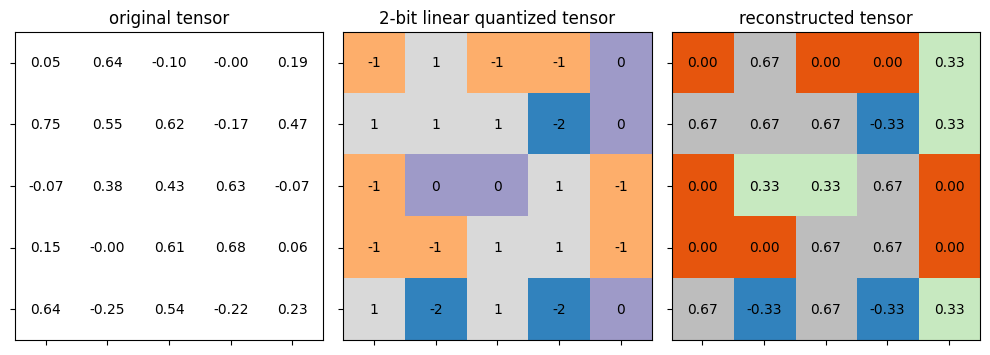

In [69]:
test_linear_quantize()

Question:  calculating the scale S and zero point Z from floating point tensor r

In [70]:
def get_quantization_scale_and_zero_point(fp_tensor, bitwidth):
    """
    get quantization scale for single tensor
    :param fp_tensor: [torch.(cuda.)Tensor] floating tensor to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [float] scale
        [int] zero_point
    """
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    fp_max = fp_tensor.max().item()
    fp_min = fp_tensor.min().item()

    ############### YOUR CODE STARTS HERE ###############
    # hint: one line of code for calculating scale
    # [VERY IMPORTANT] quantized_max - quantized_min = 2 ** bitwith - 1
    scale = (fp_max - fp_min) / (quantized_max - quantized_min)
    # hint: one line of code for calculating zero_point
    zero_point = round(quantized_min - fp_min / scale)
    ############### YOUR CODE ENDS HERE #################

    # clip the zero_point to fall in [quantized_min, quantized_max]
    if zero_point < quantized_min:
        zero_point = quantized_min
    elif zero_point > quantized_max:
        zero_point = quantized_max
    else: # convert from float to int using round()
        zero_point = round(zero_point)
    return scale, int(zero_point)

We now wrap linear_quantize() in Question 4 and get_quantization_scale_and_zero_point() in Question 5 into one function.

In [71]:
def linear_quantize_feature(fp_tensor, bitwidth):
    """
    linear quantization for feature tensor
    :param fp_tensor: [torch.(cuda.)Tensor] floating feature to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [torch.(cuda.)Tensor] quantized tensor
        [float] scale tensor
        [int] zero point
    """
    scale, zero_point = get_quantization_scale_and_zero_point(fp_tensor, bitwidth)
    quantized_tensor = linear_quantize(fp_tensor, bitwidth, scale, zero_point)
    return quantized_tensor, scale, zero_point

## Special case: linear quantization on weight tensor

Distribute of weight value

/tmp/ipykernel_35/1703871154.py:26: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


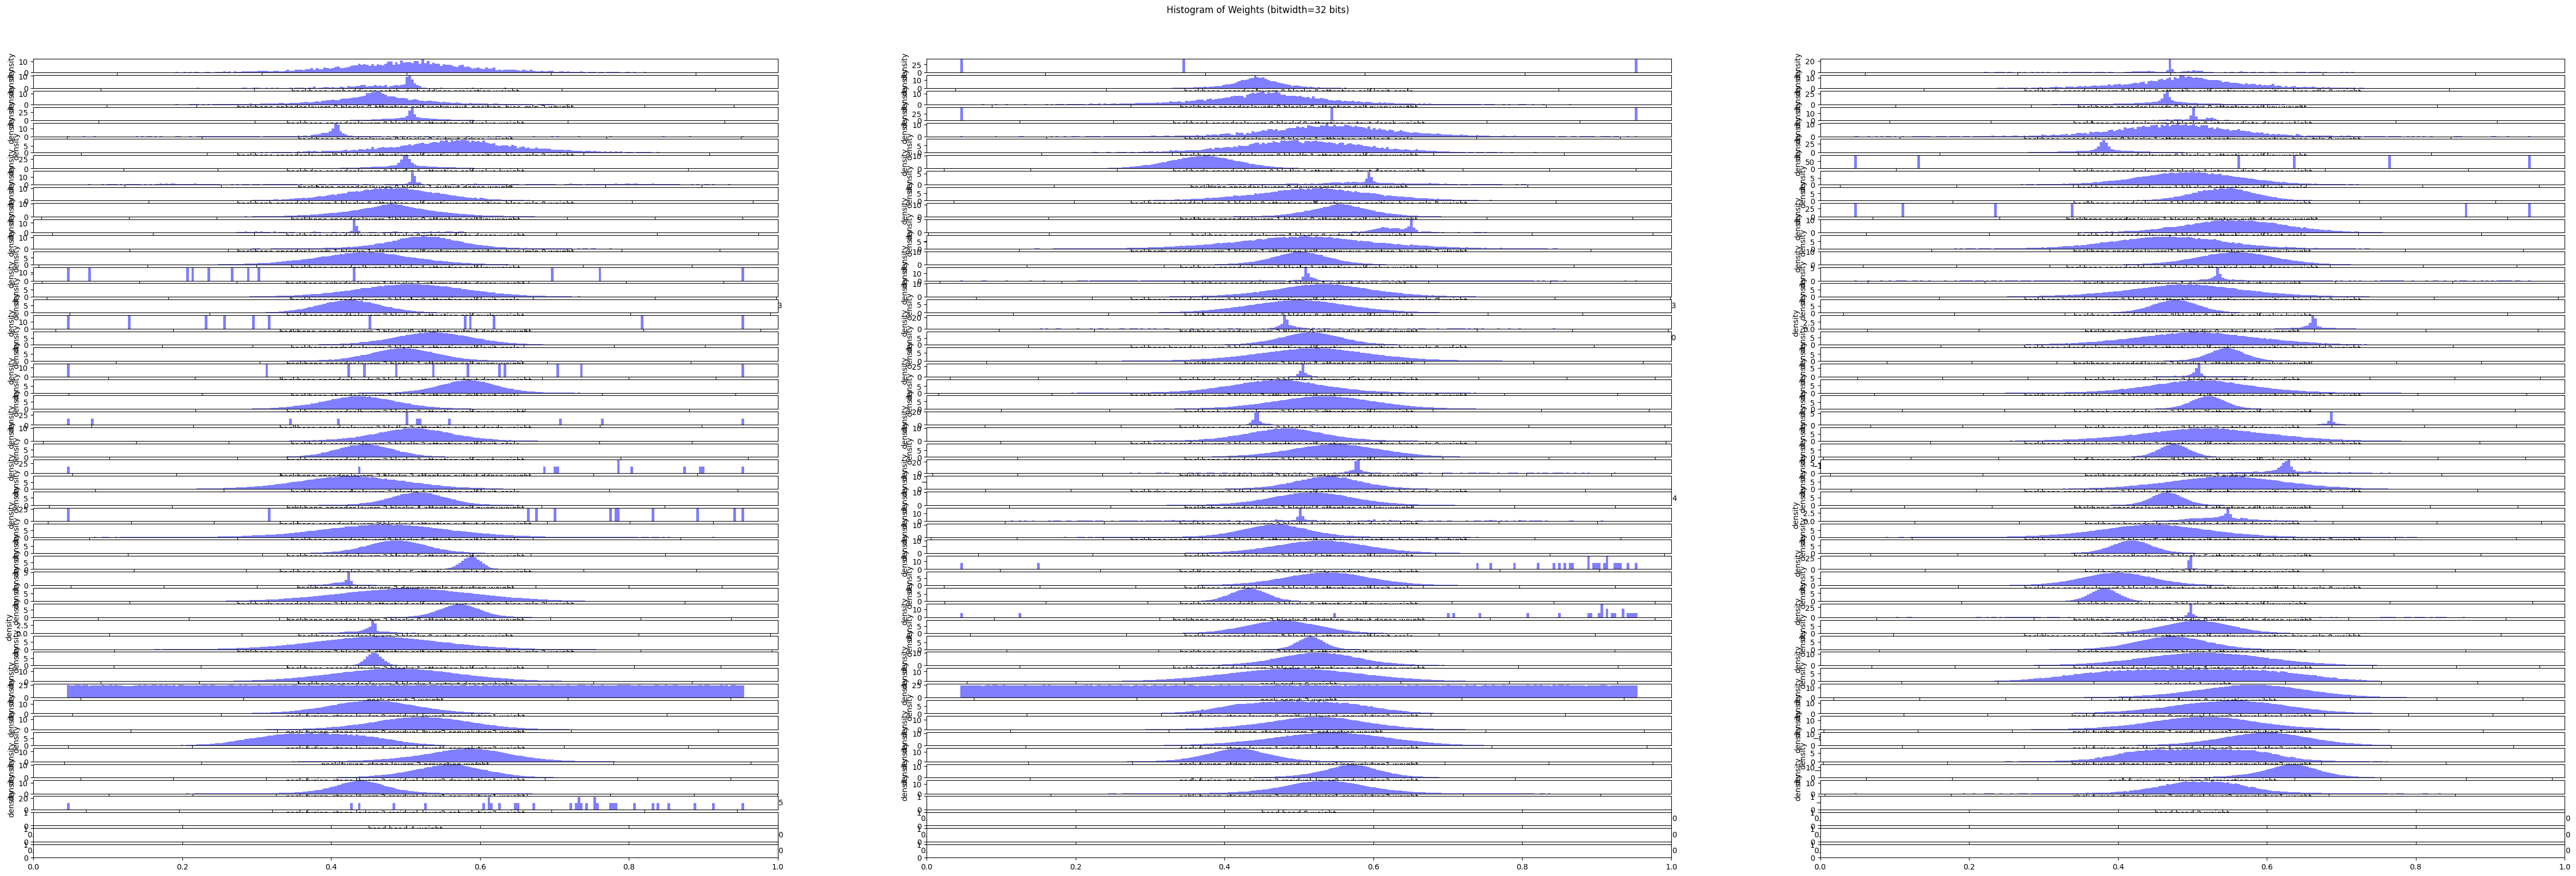

In [74]:
def plot_weight_distribution(model, bitwidth=32):
    # bins = (1 << bitwidth) if bitwidth <= 8 else 256
    if bitwidth <= 8:
        qmin, qmax = get_quantized_range(bitwidth)
        bins = np.arange(qmin, qmax + 2)
        align = 'left'
    else:
        bins = 256
        align = 'mid'
    fig, axes = plt.subplots(50,3, figsize=(20*3, 6*3))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                    align=align, color = 'blue', alpha = 0.5,
                    edgecolor='black' if bitwidth <= 4 else None)
            if bitwidth <= 4:
                quantized_min, quantized_max = get_quantized_range(bitwidth)
                ax.set_xticks(np.arange(start=quantized_min, stop=quantized_max+1))
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle(f'Histogram of Weights (bitwidth={bitwidth} bits)')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.savefig('weigt_distribution.png')
    plt.show()

recover_model()
plot_weight_distribution(model)

 the distribution of weight values are nearly symmetric about 0. Therefore, we usually make zero point Z = 0 when quantizating the weights.

In [75]:
def get_quantization_scale_for_weight(weight, bitwidth):
    """
    get quantization scale for single tensor of weight
    :param weight: [torch.(cuda.)Tensor] floating weight to be quantized
    :param bitwidth: [integer] quantization bit width
    :return:
        [floating scalar] scale
    """
    # we just assume values in weight are symmetric
    # we also always make zero_point 0 for weight
    fp_max = max(weight.abs().max().item(), 5e-7)
    _, quantized_max = get_quantized_range(bitwidth)
    return fp_max / quantized_max

## Per-channel Linear Quantization

we have to determine scaling factor S and zero point Z for the subtensor of each output channel independently.

In [76]:
def linear_quantize_weight_per_channel(tensor, bitwidth):
    """
    linear quantization for weight tensor
        using different scales and zero_points for different output channels
    :param tensor: [torch.(cuda.)Tensor] floating weight to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [torch.(cuda.)Tensor] quantized tensor
        [torch.(cuda.)Tensor] scale tensor
        [int] zero point (which is always 0)
    """
    dim_output_channels = 0
    num_output_channels = tensor.shape[dim_output_channels]
    scale = torch.zeros(num_output_channels, device=tensor.device)
    for oc in range(num_output_channels):
        _subtensor = tensor.select(dim_output_channels, oc)
        _scale = get_quantization_scale_for_weight(_subtensor, bitwidth)
        scale[oc] = _scale
    scale_shape = [1] * tensor.dim()
    scale_shape[dim_output_channels] = -1
    scale = scale.view(scale_shape)
    quantized_tensor = linear_quantize(tensor, bitwidth, scale, zero_point=0)
    return quantized_tensor, scale, 0

## A Quick Peek at Linear Quantization on Weights

/tmp/ipykernel_35/1703871154.py:26: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


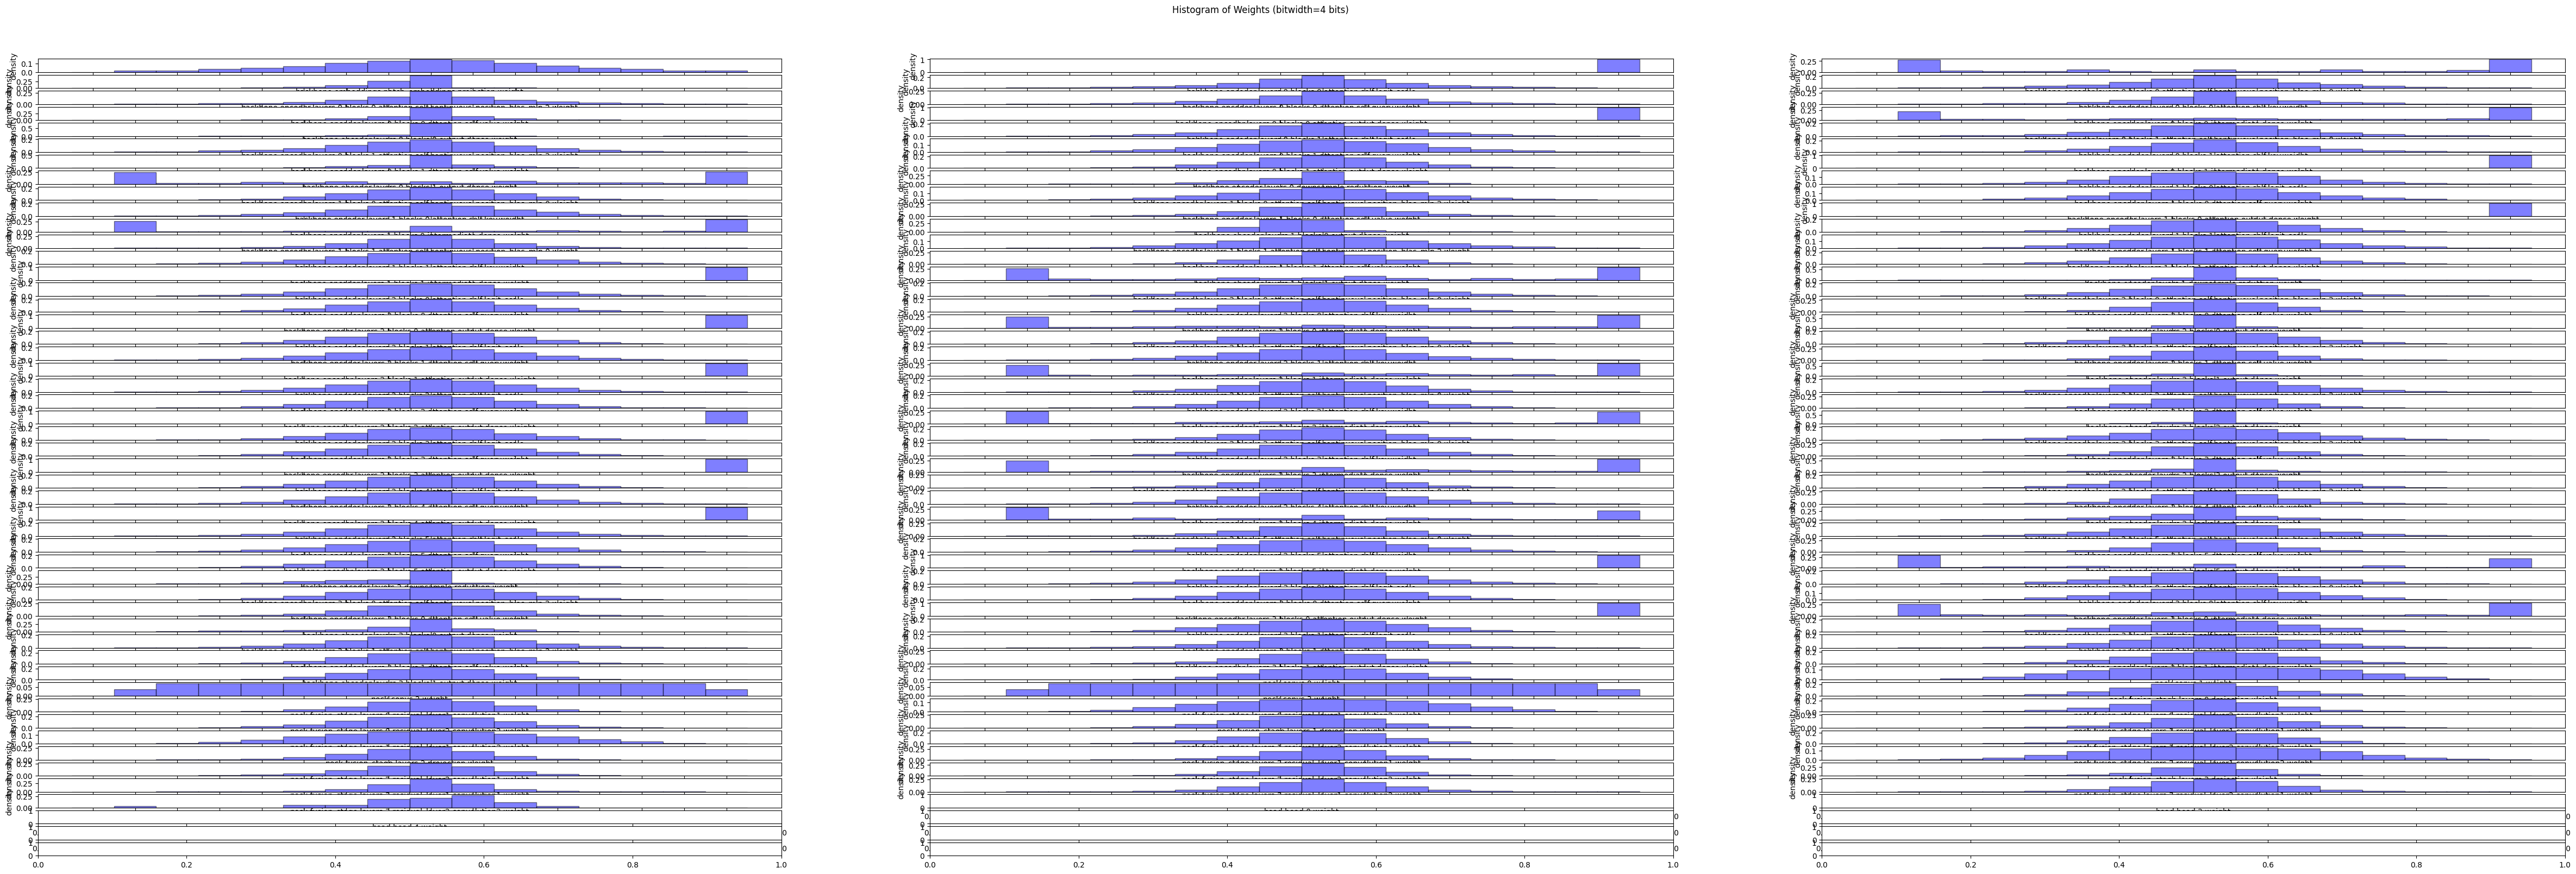

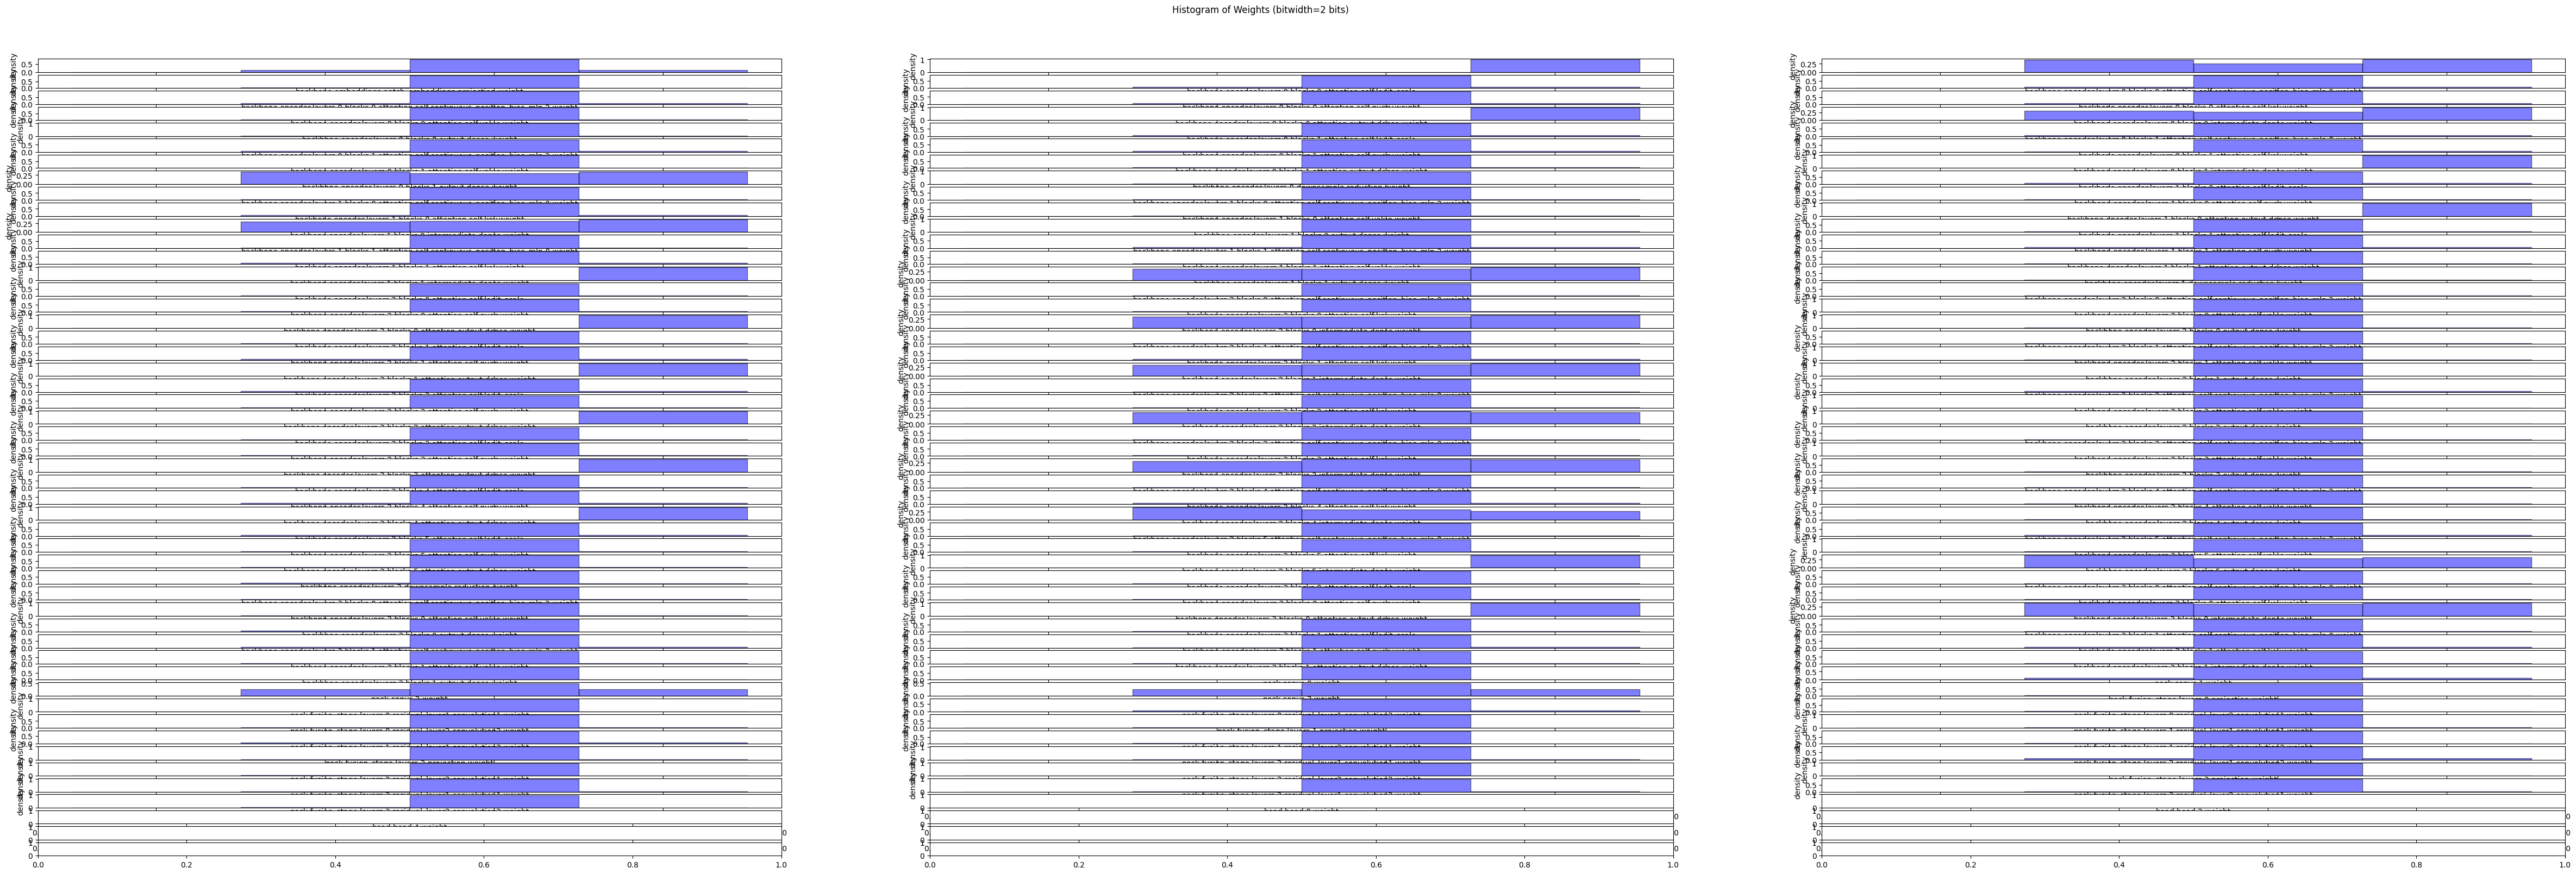

In [77]:
@torch.no_grad()
def peek_linear_quantization():
    for bitwidth in [4, 2]:
        for name, param in model.named_parameters():
            if param.dim() > 1:
                quantized_param, scale, zero_point = \
                    linear_quantize_weight_per_channel(param, bitwidth)
                param.copy_(quantized_param)
        plot_weight_distribution(model, bitwidth)
        recover_model()

peek_linear_quantization()

In [78]:
def linear_quantize_bias_per_output_channel(bias, weight_scale, input_scale):
    """
    linear quantization for single bias tensor
        quantized_bias = fp_bias / bias_scale
    :param bias: [torch.FloatTensor] bias weight to be quantized
    :param weight_scale: [float or torch.FloatTensor] weight scale tensor
    :param input_scale: [float] input scale
    :return:
        [torch.IntTensor] quantized bias tensor
    """
    assert(bias.dim() == 1)
    assert(bias.dtype == torch.float)
    assert(isinstance(input_scale, float))
    if isinstance(weight_scale, torch.Tensor):
        assert(weight_scale.dtype == torch.float)
        weight_scale = weight_scale.view(-1)
        assert(bias.numel() == weight_scale.numel())

    ############### YOUR CODE STARTS HERE ###############
    # hint: one line of code
    bias_scale = input_scale * weight_scale
    ############### YOUR CODE ENDS HERE #################

    quantized_bias = linear_quantize(bias, 32, bias_scale,
                                     zero_point=0, dtype=torch.int32)
    return quantized_bias, bias_scale, 0

## Quantized Fully-Connected Layer

In [79]:
def shift_quantized_linear_bias(quantized_bias, quantized_weight, input_zero_point):
    """
    shift quantized bias to incorporate input_zero_point for nn.Linear
        shifted_quantized_bias = quantized_bias - Linear(input_zero_point, quantized_weight)
    :param quantized_bias: [torch.IntTensor] quantized bias (torch.int32)
    :param quantized_weight: [torch.CharTensor] quantized weight (torch.int8)
    :param input_zero_point: [int] input zero point
    :return:
        [torch.IntTensor] shifted quantized bias tensor
    """
    assert(quantized_bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    return quantized_bias - quantized_weight.sum(1).to(torch.int32) * input_zero_point

Question 7: quantized fully-connected layer inference function

In [80]:
def quantized_linear(input, weight, bias, feature_bitwidth, weight_bitwidth,
                     input_zero_point, output_zero_point,
                     input_scale, weight_scale, output_scale):
    """
    quantized fully-connected layer
    :param input: [torch.CharTensor] quantized input (torch.int8)
    :param weight: [torch.CharTensor] quantized weight (torch.int8)
    :param bias: [torch.IntTensor] shifted quantized bias or None (torch.int32)
    :param feature_bitwidth: [int] quantization bit width of input and output
    :param weight_bitwidth: [int] quantization bit width of weight
    :param input_zero_point: [int] input zero point
    :param output_zero_point: [int] output zero point
    :param input_scale: [float] input feature scale
    :param weight_scale: [torch.FloatTensor] weight per-channel scale
    :param output_scale: [float] output feature scale
    :return:
        [torch.CharIntTensor] quantized output feature (torch.int8)
    """
    assert(input.dtype == torch.int8)
    assert(weight.dtype == input.dtype)
    assert(bias is None or bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    assert(isinstance(output_zero_point, int))
    assert(isinstance(input_scale, float))
    assert(isinstance(output_scale, float))
    assert(weight_scale.dtype == torch.float)

    # Step 1: integer-based fully-connected (8-bit multiplication with 32-bit accumulation)
    if 'cpu' in input.device.type:
        # use 32-b MAC for simplicity
        output = torch.nn.functional.linear(input.to(torch.int32), weight.to(torch.int32), bias)
    else:
        # current version pytorch does not yet support integer-based linear() on GPUs
        output = torch.nn.functional.linear(input.float(), weight.float(), bias.float())

    ############### YOUR CODE STARTS HERE ###############
    # Step 2: scale the output
    #         hint: 1. scales are floating numbers, we need to convert output to float as well
    #               2. the shape of weight scale is [oc, 1, 1, 1] while the shape of output is [batch_size, oc]
    output = output.float()
    output *= (input_scale * weight_scale.flatten().view(1, -1) / output_scale)


    # Step 3: shift output by output_zero_point
    #         hint: one line of code
    output = output + output_zero_point
    ############### YOUR CODE ENDS HERE #################

    # Make sure all value lies in the bitwidth-bit range
    output = output.round().clamp(*get_quantized_range(feature_bitwidth)).to(torch.int8)
    return output

Test 

In [81]:
def test_quantized_fc(
    input=torch.tensor([
        [0.6118, 0.7288, 0.8511, 0.2849, 0.8427, 0.7435, 0.4014, 0.2794],
        [0.3676, 0.2426, 0.1612, 0.7684, 0.6038, 0.0400, 0.2240, 0.4237],
        [0.6565, 0.6878, 0.4670, 0.3470, 0.2281, 0.8074, 0.0178, 0.3999],
        [0.1863, 0.3567, 0.6104, 0.0497, 0.0577, 0.2990, 0.6687, 0.8626]]),
    weight=torch.tensor([
        [ 1.2626e-01, -1.4752e-01,  8.1910e-02,  2.4982e-01, -1.0495e-01,
         -1.9227e-01, -1.8550e-01, -1.5700e-01],
        [ 2.7624e-01, -4.3835e-01,  5.1010e-02, -1.2020e-01, -2.0344e-01,
          1.0202e-01, -2.0799e-01,  2.4112e-01],
        [-3.8216e-01, -2.8047e-01,  8.5238e-02, -4.2504e-01, -2.0952e-01,
          3.2018e-01, -3.3619e-01,  2.0219e-01],
        [ 8.9233e-02, -1.0124e-01,  1.1467e-01,  2.0091e-01,  1.1438e-01,
         -4.2427e-01,  1.0178e-01, -3.0941e-04],
        [-1.8837e-02, -2.1256e-01, -4.5285e-01,  2.0949e-01, -3.8684e-01,
         -1.7100e-01, -4.5331e-01, -2.0433e-01],
        [-2.0038e-01, -5.3757e-02,  1.8997e-01, -3.6866e-01,  5.5484e-02,
          1.5643e-01, -2.3538e-01,  2.1103e-01],
        [-2.6875e-01,  2.4984e-01, -2.3514e-01,  2.5527e-01,  2.0322e-01,
          3.7675e-01,  6.1563e-02,  1.7201e-01],
        [ 3.3541e-01, -3.3555e-01, -4.3349e-01,  4.3043e-01, -2.0498e-01,
         -1.8366e-01, -9.1553e-02, -4.1168e-01]]),
    bias=torch.tensor([ 0.1954, -0.2756,  0.3113,  0.1149,  0.4274,  0.2429, -0.1721, -0.2502]),
    quantized_bias=torch.tensor([ 3, -2,  3,  1,  3,  2, -2, -2], dtype=torch.int32),
    shifted_quantized_bias=torch.tensor([-1,  0, -3, -1, -3,  0,  2, -4], dtype=torch.int32),
    calc_quantized_output=torch.tensor([
        [ 0, -1,  0, -1, -1,  0,  1, -2],
        [ 0,  0, -1,  0,  0,  0,  0, -1],
        [ 0,  0,  0, -1,  0,  0,  0, -1],
        [ 0,  0,  0,  0,  0,  1, -1, -2]], dtype=torch.int8),
    bitwidth=2, batch_size=4, in_channels=8, out_channels=8):
    def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=ListedColormap(['white'])):
        ax.imshow(tensor.cpu().numpy(), vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[0]):
            for j in range(tensor.shape[1]):
                datum = tensor[i, j].item()
                if isinstance(datum, float):
                    text = ax.text(j, i, f'{datum:.2f}',
                                    ha="center", va="center", color="k")
                else:
                    text = ax.text(j, i, f'{datum}',
                                    ha="center", va="center", color="k")

    output = torch.nn.functional.linear(input, weight, bias)

    quantized_weight, weight_scale, weight_zero_point = \
        linear_quantize_weight_per_channel(weight, bitwidth)
    quantized_input, input_scale, input_zero_point = \
        linear_quantize_feature(input, bitwidth)
    _quantized_bias, bias_scale, bias_zero_point = \
        linear_quantize_bias_per_output_channel(bias, weight_scale, input_scale)


    assert _quantized_bias.equal(quantized_bias) # original: _quantized_bias.equal(_quantized_bias)
    _shifted_quantized_bias = \
        shift_quantized_linear_bias(quantized_bias, quantized_weight, input_zero_point)
    assert _shifted_quantized_bias.equal(shifted_quantized_bias)
    quantized_output, output_scale, output_zero_point = \
        linear_quantize_feature(output, bitwidth)

    _calc_quantized_output = quantized_linear(
        quantized_input, quantized_weight, shifted_quantized_bias,
        bitwidth, bitwidth,
        input_zero_point, output_zero_point,
        input_scale, weight_scale, output_scale)

    assert _calc_quantized_output.equal(calc_quantized_output)

    reconstructed_weight = weight_scale * (quantized_weight.float() - weight_zero_point)
    reconstructed_input = input_scale * (quantized_input.float() - input_zero_point)
    reconstructed_bias = bias_scale * (quantized_bias.float() - bias_zero_point)
    reconstructed_calc_output = output_scale * (calc_quantized_output.float() - output_zero_point)

    fig, axes = plt.subplots(3,3, figsize=(15, 12))
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    plot_matrix(weight, axes[0, 0], 'original weight', vmin=-0.5, vmax=0.5)
    plot_matrix(input.t(), axes[1, 0], 'original input', vmin=0, vmax=1)
    plot_matrix(output.t(), axes[2, 0], 'original output', vmin=-1.5, vmax=1.5)
    plot_matrix(quantized_weight, axes[0, 1], f'{bitwidth}-bit linear quantized weight',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(quantized_input.t(), axes[1, 1], f'{bitwidth}-bit linear quantized input',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(calc_quantized_output.t(), axes[2, 1], f'quantized output from quantized_linear()',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(reconstructed_weight, axes[0, 2], f'reconstructed weight',
                vmin=-0.5, vmax=0.5, cmap='tab20c')
    plot_matrix(reconstructed_input.t(), axes[1, 2], f'reconstructed input',
                vmin=0, vmax=1, cmap='tab20c')
    plot_matrix(reconstructed_calc_output.t(), axes[2, 2], f'reconstructed output',
                vmin=-1.5, vmax=1.5, cmap='tab20c')

    print('* Test quantized_fc()')
    print(f'    target bitwidth: {bitwidth} bits')
    print(f'      batch size: {batch_size}')
    print(f'      input channels: {in_channels}')
    print(f'      output channels: {out_channels}')
    print('* Test passed.')
    fig.tight_layout()
    plt.show()

* Test quantized_fc()
    target bitwidth: 2 bits
      batch size: 4
      input channels: 8
      output channels: 8
* Test passed.


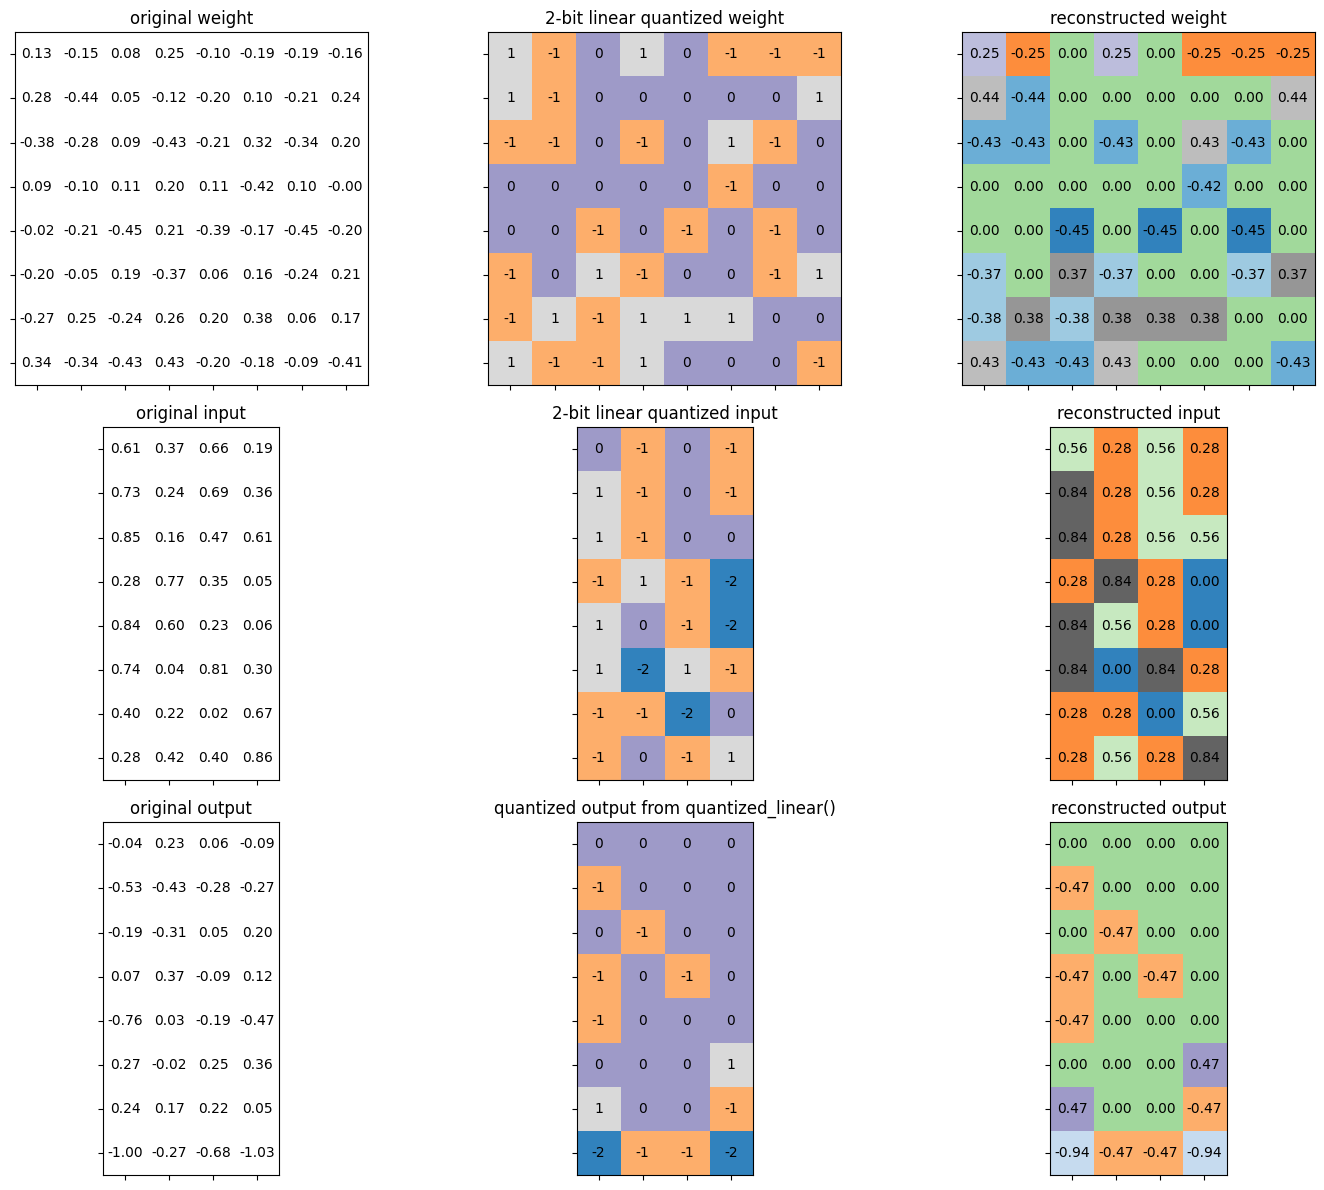

In [82]:
test_quantized_fc()

## Quantized Convolution

In [118]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
    dataset[split] = CIFAR10(
        root="data/cifar10",
        train=(split == "train"),
        download=True,
        transform=transforms[split],
      )
dataloader = {}
for split in ['train', 'test']:
    dataloader[split] = DataLoader(
        dataset[split],
        batch_size=512,
        shuffle=(split == 'train'),
        num_workers=0,
        pin_memory=True,
      )

100%|██████████| 170498071/170498071 [00:07<00:00, 22806149.12it/s]


Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10
Files already downloaded and verified


In [99]:
def download_url(url, model_dir='.', overwrite=False):
    import os, sys
    from urllib.request import urlretrieve
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)
    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
            urlretrieve(url, cached_file)
        return cached_file
    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
        return None

In [101]:
class VGG(nn.Module):
    ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

    def __init__(self) -> None:
        super().__init__()

        layers = []
        counts = defaultdict(int)

        def add(name: str, layer: nn.Module) -> None:
            layers.append((f"{name}{counts[name]}", layer))
            counts[name] += 1

        in_channels = 3
        for x in self.ARCH:
            if x != 'M':
                # conv-bn-relu
                add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
                add("bn", nn.BatchNorm2d(x))
                add("relu", nn.ReLU(True))
                in_channels = x
            else:
                # maxpool
                add("pool", nn.MaxPool2d(2))
        add("avgpool", nn.AvgPool2d(2))
        self.backbone = nn.Sequential(OrderedDict(layers))
        self.classifier = nn.Linear(512, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
        x = self.backbone(x)

        # avgpool: [N, 512, 2, 2] => [N, 512]
        # x = x.mean([2, 3])
        x = x.view(x.shape[0], -1)

        # classifier: [N, 512] => [N, 10]
        x = self.classifier(x)
        return x

In [110]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  extra_preprocess = None
) -> float:
    model.eval()

    num_samples = 0
    num_correct = 0

    for inputs, targets in tqdm(dataloader, desc="eval", leave=False):
        # Move the data from CPU to GPU
        inputs = inputs.cuda()
        if extra_preprocess is not None:
            for preprocess in extra_preprocess:
                inputs = preprocess(inputs)

        targets = targets.cuda()

        # Inference
        outputs = model(inputs)

        # Convert logits to class indices
        outputs = outputs.argmax(dim=1)

        # Update metrics
        num_samples += targets.size(0)
        num_correct += (outputs == targets).sum()

    return (num_correct / num_samples * 100).item()

In [116]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
    model.train()

    for inputs, targets in tqdm(dataloader, desc='train', leave=False):
        # Move the data from CPU to GPU
        inputs = inputs.cuda()
        targets = targets.cuda()

        # Reset the gradients (from the last iteration)
        optimizer.zero_grad()

        # Forward inference
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward propagation
        loss.backward()

        # Update optimizer and LR scheduler
        optimizer.step()
        scheduler.step()

        if callbacks is not None:
            for callback in callbacks:
                callback()

In [111]:
checkpoint_url = "https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth"
checkpoint = torch.load(download_url(checkpoint_url), map_location="cpu")
model = VGG().cuda()
print(f"=> loading checkpoint '{checkpoint_url}'")
model.load_state_dict(checkpoint['state_dict'])
recover_model = lambda : model.load_state_dict(checkpoint['state_dict'])

=> loading checkpoint 'https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth'


In [112]:
model

VGG(
  (backbone): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (pool1): MaxPo

In [113]:
def shift_quantized_conv2d_bias(quantized_bias, quantized_weight, input_zero_point):
    """
    shift quantized bias to incorporate input_zero_point for nn.Conv2d
        shifted_quantized_bias = quantized_bias - Conv(input_zero_point, quantized_weight)
    :param quantized_bias: [torch.IntTensor] quantized bias (torch.int32)
    :param quantized_weight: [torch.CharTensor] quantized weight (torch.int8)
    :param input_zero_point: [int] input zero point
    :return:
        [torch.IntTensor] shifted quantized bias tensor
    """
    assert(quantized_bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    return quantized_bias - quantized_weight.sum((1,2,3)).to(torch.int32) * input_zero_point

Question: quantized convolution function.

In [114]:
def quantized_conv2d(input, weight, bias, feature_bitwidth, weight_bitwidth,
                     input_zero_point, output_zero_point,
                     input_scale, weight_scale, output_scale,
                     stride, padding, dilation, groups):
    """
    quantized 2d convolution
    :param input: [torch.CharTensor] quantized input (torch.int8)
    :param weight: [torch.CharTensor] quantized weight (torch.int8)
    :param bias: [torch.IntTensor] shifted quantized bias or None (torch.int32)
    :param feature_bitwidth: [int] quantization bit width of input and output
    :param weight_bitwidth: [int] quantization bit width of weight
    :param input_zero_point: [int] input zero point
    :param samp: [int] output zero point
    :param input_scale: [float] input feature scale
    :param weight_scale: [torch.FloatTensor] weight per-channel scale
    :param output_scale: [float] output feature scale
    :return:
        [torch.(cuda.)CharTensor] quantized output feature
    """
    assert(len(padding) == 4)
    assert(input.dtype == torch.int8)
    assert(weight.dtype == input.dtype)
    assert(bias is None or bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    assert(isinstance(output_zero_point, int))
    assert(isinstance(input_scale, float))
    assert(isinstance(output_scale, float))
    assert(weight_scale.dtype == torch.float)

    # Step 1: calculate integer-based 2d convolution (8-bit multiplication with 32-bit accumulation)
    input = torch.nn.functional.pad(input, padding, 'constant', input_zero_point)
    if 'cpu' in input.device.type:
        # use 32-b MAC for simplicity
        output = torch.nn.functional.conv2d(input.to(torch.int32), weight.to(torch.int32), None, stride, 0, dilation, groups)
    else:
        # current version pytorch does not yet support integer-based conv2d() on GPUs
        output = torch.nn.functional.conv2d(input.float(), weight.float(), None, stride, 0, dilation, groups)
        output = output.round().to(torch.int32)
    if bias is not None:
        output = output + bias.view(1, -1, 1, 1)

    ############### YOUR CODE STARTS HERE ###############
    # hint: this code block should be the very similar to quantized_linear()

    # Step 2: scale the output
    #         hint: 1. scales are floating numbers, we need to convert output to float as well
    #               2. the shape of weight scale is [oc, 1, 1, 1] while the shape of output is [batch_size, oc, height, width]
    output = output.float()
    output *= (input_scale * weight_scale.flatten().view(1, -1, 1, 1) / output_scale)

    # Step 3: shift output by output_zero_point
    #         hint: one line of code
    output += output_zero_point
    ############### YOUR CODE ENDS HERE #################

    # Make sure all value lies in the bitwidth-bit range
    output = output.round().clamp(*get_quantized_range(feature_bitwidth)).to(torch.int8)
    return output

Question: 

 we are putting everything together and perform post-training int8 quantization for the model. We will convert the convolutional and linear layers in the model to a quantized version one-by-one.

1. Firstly, we will fuse a BatchNorm layer into its previous convolutional layer, which is a standard practice before quantization. Fusing batchnorm reduces the extra multiplication during inference

In [119]:
def fuse_conv_bn(conv, bn):
    # modified from https://mmcv.readthedocs.io/en/latest/_modules/mmcv/cnn/utils/fuse_conv_bn.html
    assert conv.bias is None

    factor = bn.weight.data / torch.sqrt(bn.running_var.data + bn.eps)
    conv.weight.data = conv.weight.data * factor.reshape(-1, 1, 1, 1)
    conv.bias = nn.Parameter(- bn.running_mean.data * factor + bn.bias.data)

    return conv

print('Before conv-bn fusion: backbone length', len(model.backbone))
#  fuse the batchnorm into conv layers
recover_model()
model_fused = copy.deepcopy(model)
fused_backbone = []
ptr = 0
while ptr < len(model_fused.backbone):
    if isinstance(model_fused.backbone[ptr], nn.Conv2d) and \
        isinstance(model_fused.backbone[ptr + 1], nn.BatchNorm2d):
        fused_backbone.append(fuse_conv_bn(
            model_fused.backbone[ptr], model_fused.backbone[ptr+ 1]))
        ptr += 2
    else:
        fused_backbone.append(model_fused.backbone[ptr])
        ptr += 1
model_fused.backbone = nn.Sequential(*fused_backbone)

print('After conv-bn fusion: backbone length', len(model_fused.backbone))
# sanity check, no BN anymore
for m in model_fused.modules():
    assert not isinstance(m, nn.BatchNorm2d)

#  the accuracy will remain the same after fusion
fused_acc = evaluate(model_fused, dataloader['test'])
print(f'Accuracy of the fused model={fused_acc:.2f}%')

Before conv-bn fusion: backbone length 29
After conv-bn fusion: backbone length 21


Accuracy of the fused model=92.95%


2. We will also verify that the fused model model_fused has the same accuracy as the original model (BN fusion is an equivalent transform that does not change network functionality).

In [121]:
# add hook to record the min max value of the activation
input_activation = {}
output_activation = {}

def add_range_recoder_hook(model):
    import functools
    def _record_range(self, x, y, module_name):
        x = x[0]
        input_activation[module_name] = x.detach()
        output_activation[module_name] = y.detach()

    all_hooks = []
    for name, m in model.named_modules():
        if isinstance(m, (nn.Conv2d, nn.Linear, nn.ReLU)):
            all_hooks.append(m.register_forward_hook(
                functools.partial(_record_range, module_name=name)))
    return all_hooks

hooks = add_range_recoder_hook(model_fused)
# sample from training data. record the scale and zero point for inference usage.
sample_data = iter(dataloader['train']).__next__()[0]
model_fused(sample_data.cuda())

# remove hooks
for h in hooks:
    h.remove()

3. Finally, let's do model quantization. We will convert the model in the following mapping

In [122]:
class QuantizedConv2d(nn.Module):
    def __init__(self, weight, bias,
                 input_zero_point, output_zero_point,
                 input_scale, weight_scale, output_scale,
                 stride, padding, dilation, groups,
                 feature_bitwidth=8, weight_bitwidth=8):
        super().__init__()
        # current version Pytorch does not support IntTensor as nn.Parameter
        self.register_buffer('weight', weight)
        self.register_buffer('bias', bias)

        self.input_zero_point = input_zero_point
        self.output_zero_point = output_zero_point

        self.input_scale = input_scale
        self.register_buffer('weight_scale', weight_scale)
        self.output_scale = output_scale

        self.stride = stride
        self.padding = (padding[1], padding[1], padding[0], padding[0])
        self.dilation = dilation
        self.groups = groups

        self.feature_bitwidth = feature_bitwidth
        self.weight_bitwidth = weight_bitwidth


    def forward(self, x):
        return quantized_conv2d(
            x, self.weight, self.bias,
            self.feature_bitwidth, self.weight_bitwidth,
            self.input_zero_point, self.output_zero_point,
            self.input_scale, self.weight_scale, self.output_scale,
            self.stride, self.padding, self.dilation, self.groups
            )

class QuantizedLinear(nn.Module):
    def __init__(self, weight, bias,
                 input_zero_point, output_zero_point,
                 input_scale, weight_scale, output_scale,
                 feature_bitwidth=8, weight_bitwidth=8):
        super().__init__()
        # current version Pytorch does not support IntTensor as nn.Parameter
        self.register_buffer('weight', weight)
        self.register_buffer('bias', bias)

        self.input_zero_point = input_zero_point
        self.output_zero_point = output_zero_point

        self.input_scale = input_scale
        self.register_buffer('weight_scale', weight_scale)
        self.output_scale = output_scale

        self.feature_bitwidth = feature_bitwidth
        self.weight_bitwidth = weight_bitwidth

    def forward(self, x):
        return quantized_linear(
            x, self.weight, self.bias,
            self.feature_bitwidth, self.weight_bitwidth,
            self.input_zero_point, self.output_zero_point,
            self.input_scale, self.weight_scale, self.output_scale
            )

class QuantizedMaxPool2d(nn.MaxPool2d):
    def forward(self, x):
        # current version PyTorch does not support integer-based MaxPool
        return super().forward(x.float()).to(torch.int8)

class QuantizedAvgPool2d(nn.AvgPool2d):
    def forward(self, x):
        # current version PyTorch does not support integer-based AvgPool
        return super().forward(x.float()).to(torch.int8)

# we use int8 quantization, which is quite popular
feature_bitwidth = weight_bitwidth = 8
quantized_model = copy.deepcopy(model_fused)
quantized_backbone = []
ptr = 0
while ptr < len(quantized_model.backbone):
    if isinstance(quantized_model.backbone[ptr], nn.Conv2d) and \
        isinstance(quantized_model.backbone[ptr + 1], nn.ReLU):
        conv = quantized_model.backbone[ptr]
        conv_name = f'backbone.{ptr}'
        relu = quantized_model.backbone[ptr + 1]
        relu_name = f'backbone.{ptr + 1}'

        input_scale, input_zero_point = \
            get_quantization_scale_and_zero_point(
                input_activation[conv_name], feature_bitwidth)

        output_scale, output_zero_point = \
            get_quantization_scale_and_zero_point(
                output_activation[relu_name], feature_bitwidth)

        quantized_weight, weight_scale, weight_zero_point = \
            linear_quantize_weight_per_channel(conv.weight.data, weight_bitwidth)
        quantized_bias, bias_scale, bias_zero_point = \
            linear_quantize_bias_per_output_channel(
                conv.bias.data, weight_scale, input_scale)
        shifted_quantized_bias = \
            shift_quantized_conv2d_bias(quantized_bias, quantized_weight,
                                        input_zero_point)

        quantized_conv = QuantizedConv2d(
            quantized_weight, shifted_quantized_bias,
            input_zero_point, output_zero_point,
            input_scale, weight_scale, output_scale,
            conv.stride, conv.padding, conv.dilation, conv.groups,
            feature_bitwidth=feature_bitwidth, weight_bitwidth=weight_bitwidth
        )

        quantized_backbone.append(quantized_conv)
        ptr += 2
    elif isinstance(quantized_model.backbone[ptr], nn.MaxPool2d):
        quantized_backbone.append(QuantizedMaxPool2d(
            kernel_size=quantized_model.backbone[ptr].kernel_size,
            stride=quantized_model.backbone[ptr].stride
            ))
        ptr += 1
    elif isinstance(quantized_model.backbone[ptr], nn.AvgPool2d):
        quantized_backbone.append(QuantizedAvgPool2d(
            kernel_size=quantized_model.backbone[ptr].kernel_size,
            stride=quantized_model.backbone[ptr].stride
            ))
        ptr += 1
    else:
        raise NotImplementedError(type(quantized_model.backbone[ptr]))  # should not happen
quantized_model.backbone = nn.Sequential(*quantized_backbone)

# finally, quantized the classifier
fc_name = 'classifier'
fc = model.classifier
input_scale, input_zero_point = \
    get_quantization_scale_and_zero_point(
        input_activation[fc_name], feature_bitwidth)

output_scale, output_zero_point = \
    get_quantization_scale_and_zero_point(
        output_activation[fc_name], feature_bitwidth)

quantized_weight, weight_scale, weight_zero_point = \
    linear_quantize_weight_per_channel(fc.weight.data, weight_bitwidth)
quantized_bias, bias_scale, bias_zero_point = \
    linear_quantize_bias_per_output_channel(
        fc.bias.data, weight_scale, input_scale)
shifted_quantized_bias = \
    shift_quantized_linear_bias(quantized_bias, quantized_weight,
                                input_zero_point)

quantized_model.classifier = QuantizedLinear(
    quantized_weight, shifted_quantized_bias,
    input_zero_point, output_zero_point,
    input_scale, weight_scale, output_scale,
    feature_bitwidth=feature_bitwidth, weight_bitwidth=weight_bitwidth
)

To run the quantized model, we need an extra preprocessing to map the input data from range (0, 1) into int8 range of (-128, 127). Fill in the code below to finish the extra preprocessing

In [123]:
print(quantized_model)

def extra_preprocess(x):
    # hint: you need to convert the original fp32 input of range (0, 1)
    #  into int8 format of range (-128, 127)
    ############### YOUR CODE STARTS HERE ###############
    return (x * 255 - 128).clamp(-128, 127).to(torch.int8)
    ############### YOUR CODE ENDS HERE #################

int8_model_accuracy = evaluate(quantized_model, dataloader['test'],
                               extra_preprocess=[extra_preprocess])
print(f"int8 model has accuracy={int8_model_accuracy:.2f}%")

VGG(
  (backbone): Sequential(
    (0): QuantizedConv2d()
    (1): QuantizedConv2d()
    (2): QuantizedMaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): QuantizedConv2d()
    (4): QuantizedConv2d()
    (5): QuantizedMaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): QuantizedConv2d()
    (7): QuantizedConv2d()
    (8): QuantizedMaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): QuantizedConv2d()
    (10): QuantizedConv2d()
    (11): QuantizedMaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): QuantizedAvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): QuantizedLinear()
)


int8 model has accuracy=92.86%
